<a href="https://colab.research.google.com/github/CoreTheGreat/HBPU-Machine-Learning-Course/blob/main/ML_Chapter3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 实验四：基于分类模型的手写字母识别
湖北理工学院《机器学习》课程NoteBook

学生：吴兴平

笔记内容概述:
* 3.1 逻辑回归与二分类问题
* 3.2 常用的二分类模型——支持向量机
* 3.3 常用的二分类模型——决策树
* 3.4 二分类模型的度量
* 3.5 由二分类到多分类


## 3.1 逻辑回归与二分类问题

### 3.1.1 利用torchvision载入训练数据MINST

MINST是一个小型的基于灰度图像(图像大小1x28x28)的手写字母识别数据集，包含60000个训练数据，10000个测试数据。

Image size is (28, 28)


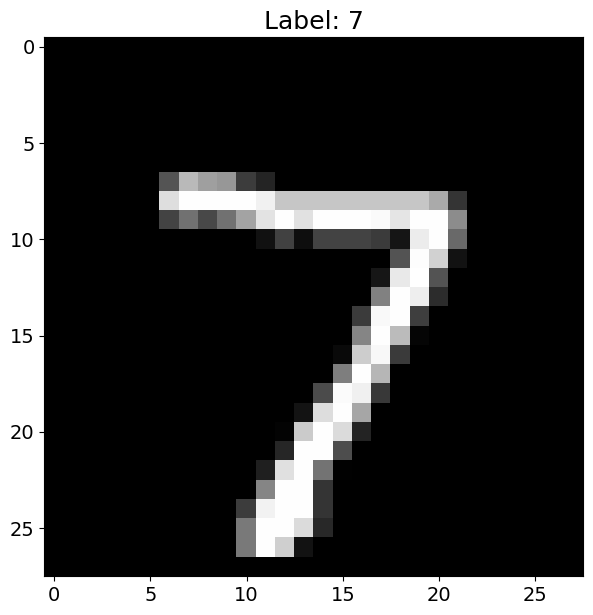

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import numpy as np

from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import roc_curve, auc

import time

import matplotlib
import matplotlib.pyplot as plt

color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

label_size = 18 # Label size
ticklabel_size = 14 # Tick label size

# Load the MNIST dataset to display
imgDisp = torchvision.datasets.MNIST(root='./data', train=False, download=True)
img, label = imgDisp[0]

print(f'Image size is {img.size}')

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(img, cmap='gray') # Display image
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
ax.set_title(f"Label: {label}", fontsize=label_size)
# plt.savefig(f'exp_character{label}.png', dpi=300) # Make figure clearer
plt.show()

构建ftrExtract类，在读取数据的时候提取样本的特征

In [3]:
class ftrExtract(object):
    '''
    This class is used to extract features of images
    '''
    def __call__(self, tensor):
        tensor = tensor.squeeze() # Compress redundant demensions

        mean_width = tensor.mean(axis=0)
        mean_height = tensor.mean(axis=1)

        std_width = tensor.std(axis=0)
        std_height = tensor.std(axis=1)

        ftrs = torch.cat([mean_width, mean_height, std_width, std_height])

        return ftrs

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), ftrExtract()])

# Load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

# Count number of each class in trainset
train_class_counts = {}
for _, label in trainset:
    if label not in train_class_counts:
        train_class_counts[label] = 0
    train_class_counts[label] += 1

# Count number of each class in testset
test_class_counts = {}
for _, label in testset:
    if label not in test_class_counts:
        test_class_counts[label] = 0
    test_class_counts[label] += 1

# Print results
for i in range(10):
    cls_counts_train = train_class_counts.get(i, 0)
    cls_ratio_train = cls_counts_train / len(trainset)
    cls_counts_test = test_class_counts.get(i, 0)
    cls_ratio_test = cls_counts_test / len(testset)

    print(f"Class {i}: Trainset - {cls_counts_train} ({cls_ratio_train:.2%}), Testset - {cls_counts_test} ({cls_ratio_test:.2%})")

batch_size = 42
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

# Get a batch of training data
dataiter = iter(trainloader)
data, labels = next(dataiter)

input_size = data[0].numpy().shape[0]
print(f'Input_size is {input_size}')

Class 0: Trainset - 5923 (9.87%), Testset - 980 (9.80%)
Class 1: Trainset - 6742 (11.24%), Testset - 1135 (11.35%)
Class 2: Trainset - 5958 (9.93%), Testset - 1032 (10.32%)
Class 3: Trainset - 6131 (10.22%), Testset - 1010 (10.10%)
Class 4: Trainset - 5842 (9.74%), Testset - 982 (9.82%)
Class 5: Trainset - 5421 (9.04%), Testset - 892 (8.92%)
Class 6: Trainset - 5918 (9.86%), Testset - 958 (9.58%)
Class 7: Trainset - 6265 (10.44%), Testset - 1028 (10.28%)
Class 8: Trainset - 5851 (9.75%), Testset - 974 (9.74%)
Class 9: Trainset - 5949 (9.92%), Testset - 1009 (10.09%)
Input_size is 112


### 3.1.2 使用线性回归识别手写字母

In [4]:
# Convert data to numpy arrays
X_train = []
y_train = []
for batch_image, batch_label in trainloader:
    X_train.append(batch_image.view(-1, input_size).numpy())
    y_train.append(batch_label.numpy())

X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)

print(f'Shapes of X_train and Y_train: {X_train.shape} and {y_train.shape}')

X_test = []
y_test = []
for batch_image, batch_label in testloader:
    X_test.append(batch_image.view(-1, input_size).numpy())
    y_test.append(batch_label.numpy())

X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)

print(f'Shapes of X_test and y_test: {X_test.shape} and {y_test.shape}')

Shapes of X_train and Y_train: (60000, 112) and (60000,)
Shapes of X_test and y_test: (10000, 112) and (10000,)


使用回归的方法做分类

In [5]:
# Initialize the linear regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Round predictions to nearest integer for classification
y_pred_constrained = np.clip(y_pred, 0, np.max(y_test))
y_pred_rounded = np.round(y_pred_constrained).astype(int)
print(f"Predicted classes: {np.unique(y_pred_rounded)}")

# Calculate accuracy
accuracy = np.mean(y_pred_rounded == y_test)
print(f"Real classes: {np.unique(y_test)}")
print(f"Accuracy of linear regression model: {accuracy:.4f}")

Predicted classes: [0 1 2 3 4 5 6 7 8 9]
Real classes: [0 1 2 3 4 5 6 7 8 9]
Accuracy of linear regression model: 0.2435


用混淆矩阵展示线性回归分类的结果

In [6]:
def manual_confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t][p] += 1
    return cm

# Get number of character types
num_classes = len(np.unique(y_test)) 

# Calculate confusion matrix
cm = manual_confusion_matrix(y_test, y_pred_rounded, num_classes)

# Print the results in the specified format
for i in range(num_classes):
    output = f"Real label {i}, "
    for j in range(num_classes):
        output += f"Predict label {j} ({cm[i, j]}), "
    print(output[:-2])  # Remove the last comma and space

Real label 0, Predict label 0 (168), Predict label 1 (284), Predict label 2 (300), Predict label 3 (164), Predict label 4 (46), Predict label 5 (12), Predict label 6 (6), Predict label 7 (0), Predict label 8 (0), Predict label 9 (0)
Real label 1, Predict label 0 (40), Predict label 1 (332), Predict label 2 (389), Predict label 3 (278), Predict label 4 (78), Predict label 5 (14), Predict label 6 (3), Predict label 7 (0), Predict label 8 (0), Predict label 9 (1)
Real label 2, Predict label 0 (20), Predict label 1 (85), Predict label 2 (230), Predict label 3 (366), Predict label 4 (233), Predict label 5 (76), Predict label 6 (18), Predict label 7 (4), Predict label 8 (0), Predict label 9 (0)
Real label 3, Predict label 0 (0), Predict label 1 (10), Predict label 2 (90), Predict label 3 (264), Predict label 4 (344), Predict label 5 (198), Predict label 6 (82), Predict label 7 (15), Predict label 8 (6), Predict label 9 (1)
Real label 4, Predict label 0 (3), Predict label 1 (3), Predict label

画混淆矩阵图

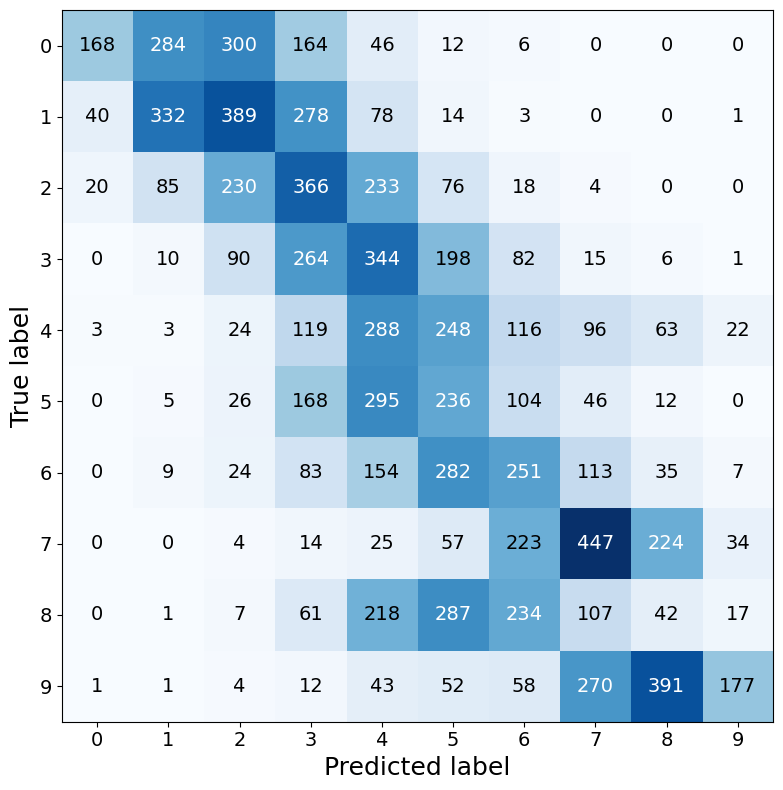

In [7]:
# Now let's create the confusion matrix plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the confusion matrix as a heatmap
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Set up the axes
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=np.arange(10), yticklabels=np.arange(10),
       xlabel='Predicted label', ylabel='True label')

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontsize=ticklabel_size,
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Adjust font sizes
ax.set_xlabel('Predicted label', fontsize=label_size)
ax.set_ylabel('True label', fontsize=label_size)

ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

# Tight layout to ensure everything fits
fig.tight_layout()

# Save the figure if needed
# plt.savefig('Regression_for_classification.png', dpi=300, bbox_inches='tight')

plt.show()

使用逻辑回归做分类

In [8]:
# Initialize the linear regression model
lr_model = LogisticRegression(max_iter=1000)

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)

# Round predictions to nearest integer for classification
y_pred_rounded = np.round(y_pred).astype(int)
print(f"Predicted classes: {np.unique(y_pred_rounded)}")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of logistic regression model: {accuracy:.4f}")

# Calculate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

Predicted classes: [0 1 2 3 4 5 6 7 8 9]
Accuracy of logistic regression model: 0.8730

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       980
           1       0.93      0.96      0.95      1135
           2       0.87      0.84      0.85      1032
           3       0.80      0.83      0.82      1010
           4       0.91      0.91      0.91       982
           5       0.77      0.69      0.73       892
           6       0.91      0.92      0.92       958
           7       0.90      0.89      0.89      1028
           8       0.83      0.83      0.83       974
           9       0.86      0.88      0.87      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



用混淆矩阵展示逻辑回归的分类结果

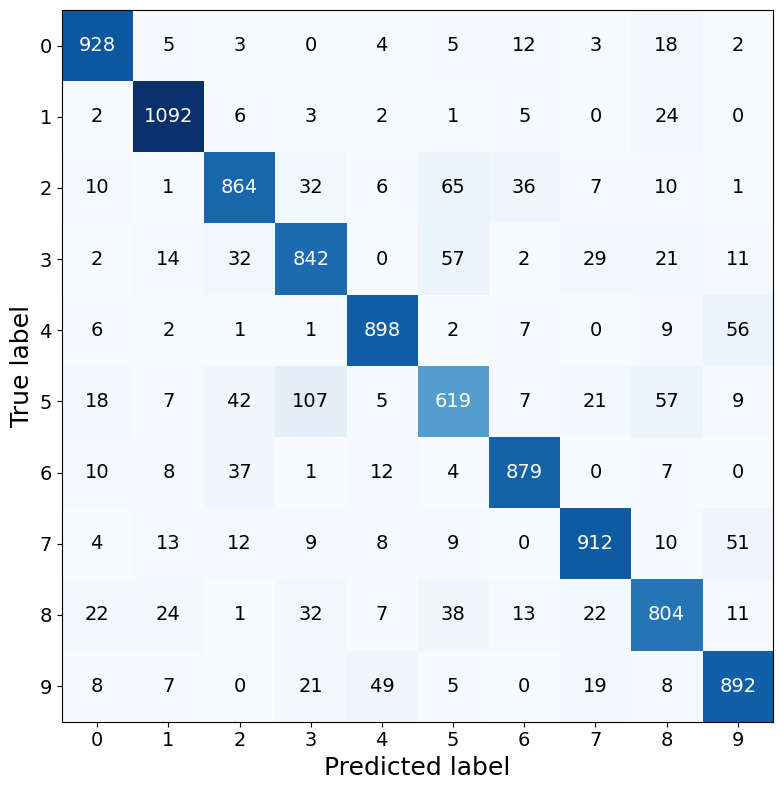

In [9]:
# Now let's create the confusion matrix plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the confusion matrix as a heatmap
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Set up the axes
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=np.arange(10), yticklabels=np.arange(10),
       xlabel='Predicted label', ylabel='True label')

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontsize=ticklabel_size,
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Adjust font sizes
ax.set_xlabel('Predicted label', fontsize=label_size)
ax.set_ylabel('True label', fontsize=label_size)

ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

# Tight layout to ensure everything fits
fig.tight_layout()

# Save the figure if needed
# plt.savefig('Logicregression_for_classification.png', dpi=300, bbox_inches='tight')

plt.show()

选择三个随机样本来展示输出的形式，尤其是Softmax前后的概率分布

In [10]:
# Select an example of character 1 randomly
# Select an example of 1 randomly
char_1_indices = np.where(y_test == 1)[0]
random_char_1_index = np.random.choice(char_1_indices)
random_char_1 = X_test[random_char_1_index]

# Select an example of 2 randomly
char_2_indices = np.where(y_test == 2)[0]
random_char_2_index = np.random.choice(char_2_indices)
random_char_2 = X_test[random_char_2_index]

# Select an example of 6 randomly
char_6_indices = np.where(y_test == 6)[0]
random_char_6_index = np.random.choice(char_6_indices)
random_char_6 = X_test[random_char_6_index]

# Get predictions and probabilities for these examples
examples = [random_char_1, random_char_2, random_char_6]
example_predictions = lr_model.predict(examples)
example_probabilities = lr_model.predict_proba(examples)

print("Predicted classes: ", example_predictions)

# Display probabilities in percentage style, one line per example
print("Probabilities:")
for i, probs in enumerate(example_probabilities):
    prob_strings = [f"{prob:.2%}" for _, prob in enumerate(probs)]
    print(f"Example {i+1}: {', '.join(prob_strings)}")

Predicted classes:  [1 6 6]
Probabilities:
Example 1: 0.01%, 99.13%, 0.00%, 0.00%, 0.30%, 0.00%, 0.01%, 0.00%, 0.54%, 0.00%
Example 2: 0.11%, 0.00%, 0.59%, 0.00%, 0.00%, 0.11%, 99.16%, 0.00%, 0.03%, 0.00%
Example 3: 0.00%, 0.00%, 0.02%, 0.00%, 0.01%, 0.01%, 99.93%, 0.00%, 0.01%, 0.00%


### 3.1.3 生成虚拟样本解释为什么不建议使用线性回归做分类

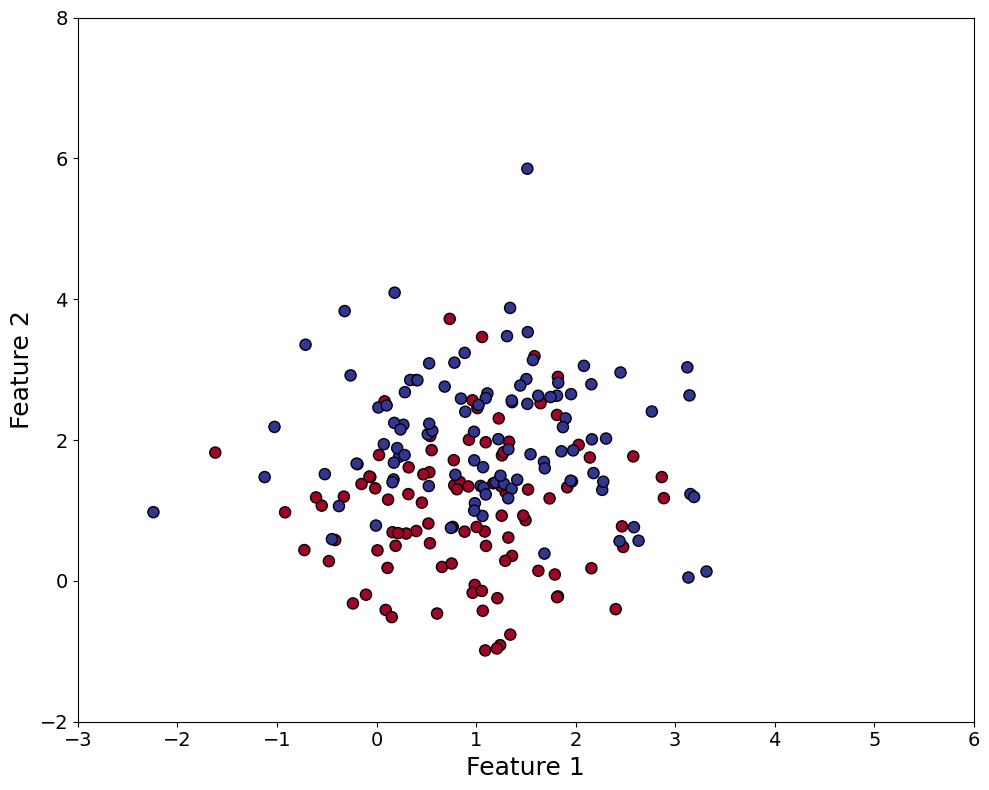

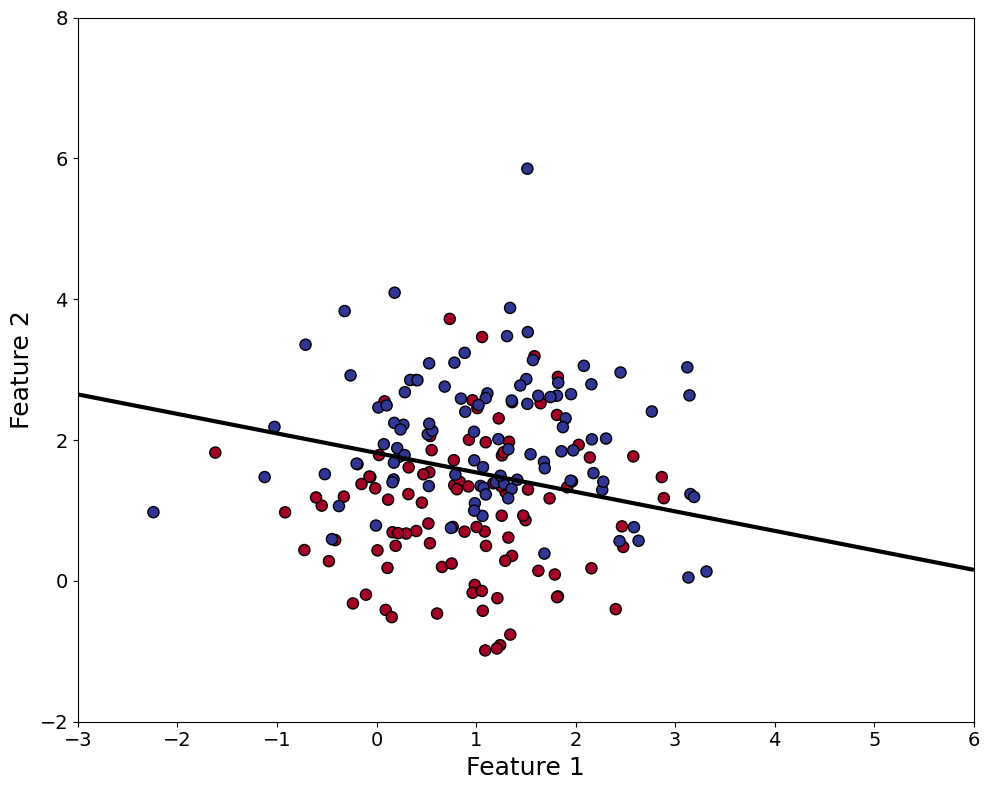

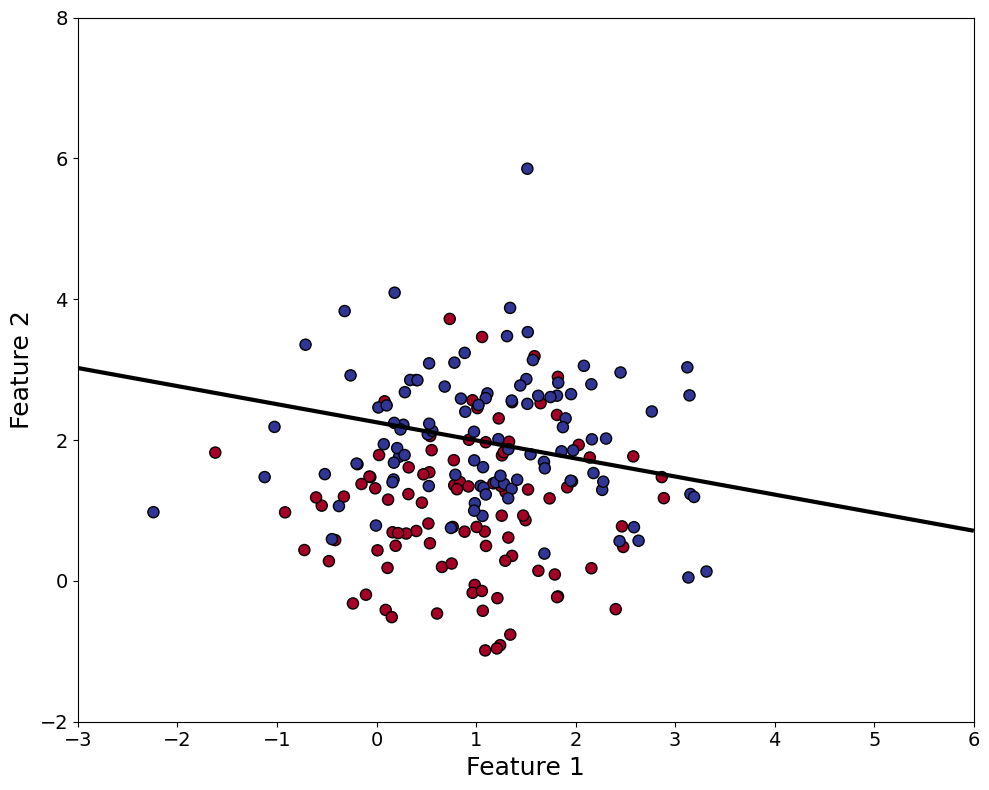

Init Linear Regression Decision Boundary:
y = 0.115 + 0.059*x1 + 0.212*x2

Init Logistic Regression Decision Boundary:
y = -1.932 + 0.277*x1 + 1.080*x2


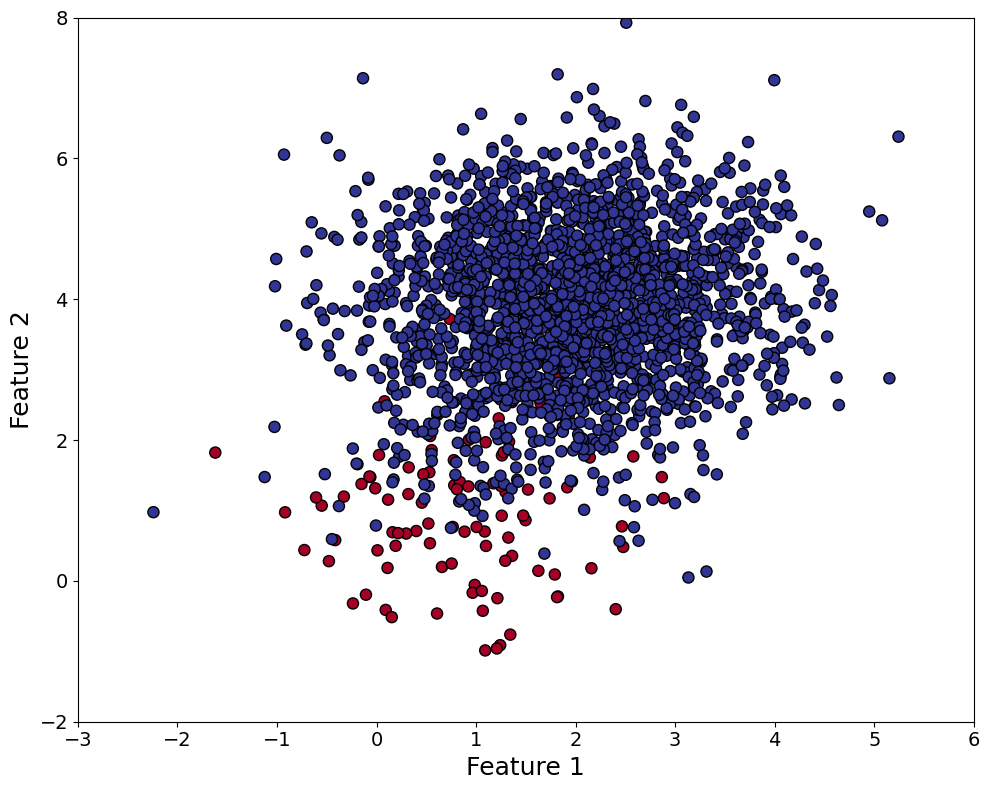

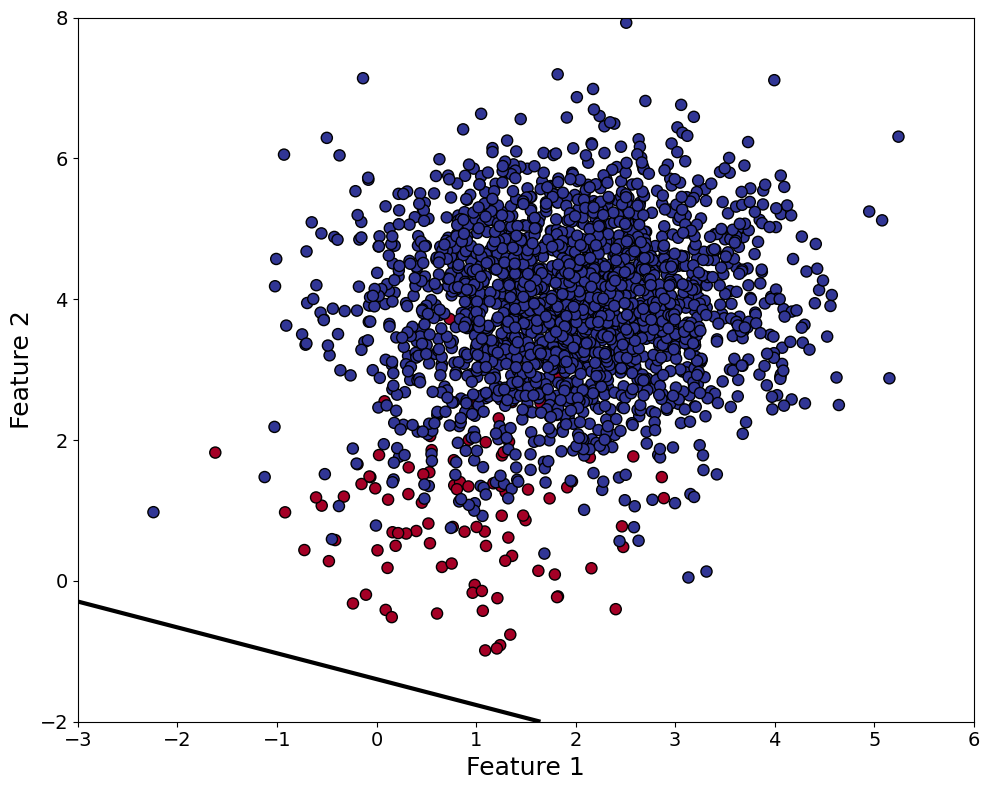

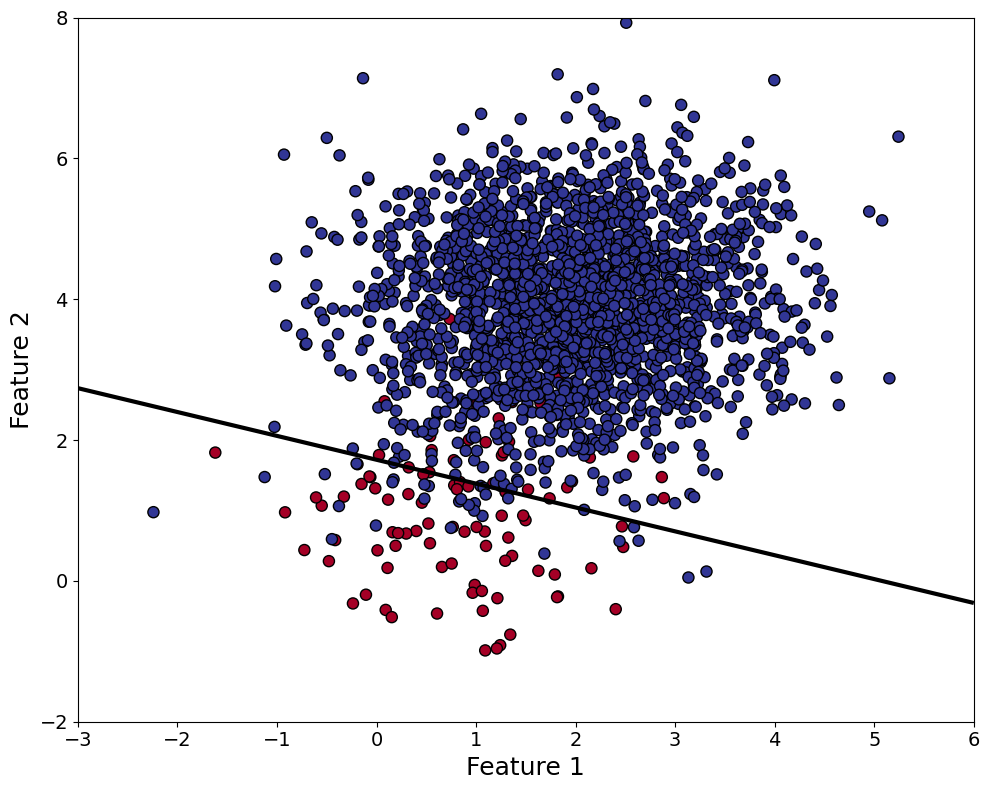

Linear Regression Decision Boundary:
y = 0.608 + 0.028*x1 + 0.077*x2

Logistic Regression Decision Boundary:
y = -3.054 + 0.700*x1 + 2.067*x2


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression

x_min, x_max = (-3, 6)
y_min, y_max = (-2, 8)
    
# Function to plot decision boundary
def plot_decision_boundary(ax, model, X, y, only_scatter=False):
    global ticklabel_size, label_size
    global x_min, x_max
    global y_min, y_max
    
    # Display samples
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=8**2)
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    X_plot = np.c_[xx.ravel(), yy.ravel()]
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    ax.set_xlabel('Feature 1', fontsize=label_size)
    ax.set_ylabel('Feature 2', fontsize=label_size)
    
    if not only_scatter:
        # Display the decision lines
        if isinstance(model, LinearRegression):
            Z = model.predict(X_plot)
        else:  # LogisticRegression
            Z = model.decision_function(X_plot)
            
        Z = Z.reshape(xx.shape)    
        ax.contour(xx, yy, Z, levels=[0.5], colors='k', linestyles=['-'], linewidths=3)   
        
# Set random seed for reproducibility
np.random.seed(42)

# Generate two dense sets
n_samples = 100
set1 = np.random.randn(n_samples, 2) + np.array([1, 1])
set2 = np.random.randn(n_samples, 2) + np.array([1, 2])

X = np.vstack([set1, set2])
y = np.hstack([np.zeros(n_samples), np.ones(n_samples)])

# Fit linear regression and logistic regression
lr_model_init = LinearRegression()
lr_model_init.fit(X, y)

fig, ax0 = plt.subplots(figsize=(10, 8))
plot_decision_boundary(ax0, lr_model_init, X, y, only_scatter=True)
plt.tight_layout()
# plt.savefig('biclassification_scatter_init.png', dpi=300)
plt.show()

# Plot initial decision boundary line of linear regression
fig, ax1 = plt.subplots(figsize=(10, 8))
plot_decision_boundary(ax1, lr_model_init, X, y)
plt.tight_layout()
# plt.savefig('linear_biclassification_init.png', dpi=300)
plt.show()

log_model_init = LogisticRegression(max_iter=1000)
log_model_init.fit(X, y) 

# Plot initial decision boundary line of logistic regression
fig, ax2 = plt.subplots(figsize=(10, 8))
plot_decision_boundary(ax2, log_model_init, X, y)
plt.tight_layout()
# plt.savefig('logistic_biclassification_init.png', dpi=300)
plt.show()

# Print decision boundaries
print("Init Linear Regression Decision Boundary:")
print(f"y = {lr_model_init.intercept_:.3f} + {lr_model_init.coef_[0]:.3f}*x1 + {lr_model_init.coef_[1]:.3f}*x2")

print("\nInit Logistic Regression Decision Boundary:")
print(f"y = {log_model_init.intercept_[0]:.3f} + {log_model_init.coef_[0][0]:.3f}*x1 + {log_model_init.coef_[0][1]:.3f}*x2")

# Add a third set far from the first two
n_samples = 20 * n_samples
set3 = np.random.randn(n_samples, 2) + np.array([2, 4])
X_new = np.vstack([X, set3])
y_new = np.hstack([y, np.ones(n_samples)])

# Refit the models
lr_model_update = LinearRegression()
lr_model_update.fit(X_new, y_new)

fig, ax3 = plt.subplots(figsize=(10, 8))
plot_decision_boundary(ax3, lr_model_update, X_new, y_new, only_scatter=True)
plt.tight_layout()
# plt.savefig('biclassification_scatter_update.png', dpi=300)
plt.show()

log_model_update = LogisticRegression(max_iter=1000)
log_model_update.fit(X_new, y_new)

# Plot initial decision boundary line of linear regression
fig, ax4 = plt.subplots(figsize=(10, 8))
plot_decision_boundary(ax4, lr_model_update, X_new, y_new)
plt.tight_layout()
# plt.savefig('linear_biclassification_update.png', dpi=300)
plt.show()

# Plot initial decision boundary line of logistic regression
fig, ax5 = plt.subplots(figsize=(10, 8))
plot_decision_boundary(ax5, log_model_update, X_new, y_new)
plt.tight_layout()
# plt.savefig('logistic_biclassification_update.png', dpi=300)
plt.show()

# Print decision boundaries
print("Linear Regression Decision Boundary:")
print(f"y = {lr_model_update.intercept_:.3f} + {lr_model_update.coef_[0]:.3f}*x1 + {lr_model_update.coef_[1]:.3f}*x2")

print("\nLogistic Regression Decision Boundary:")
print(f"y = {log_model_update.intercept_[0]:.3f} + {log_model_update.coef_[0][0]:.3f}*x1 + {log_model_update.coef_[0][1]:.3f}*x2")


画出分类边界，进一步解释不用线性回归做分类的原因

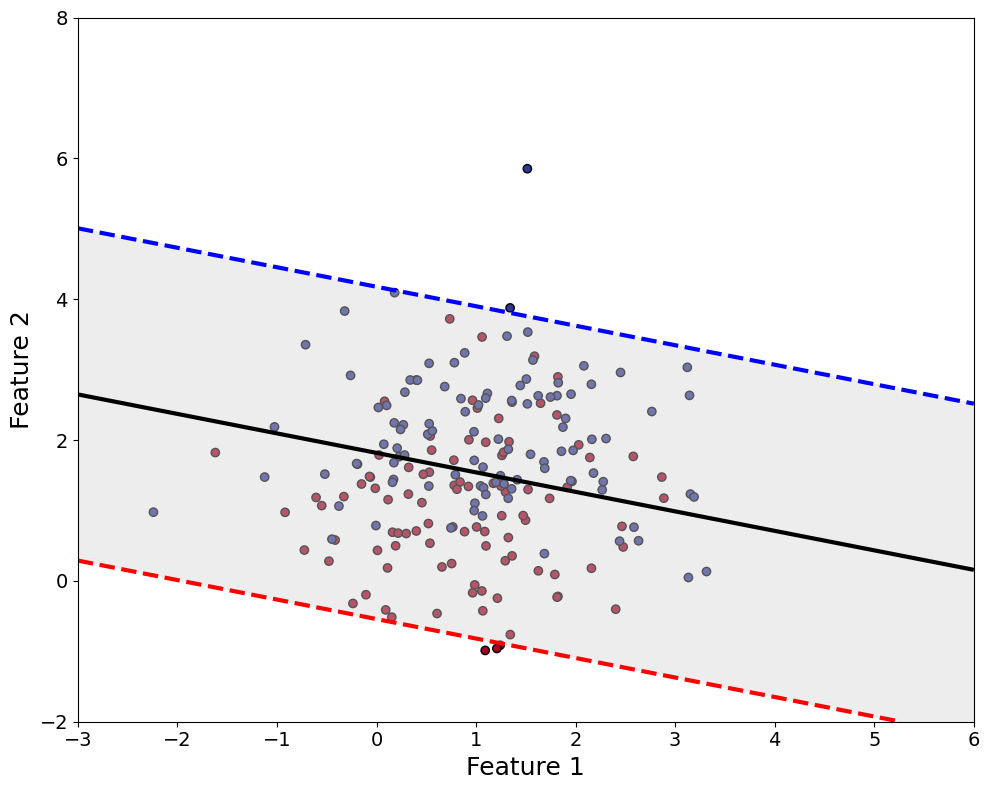

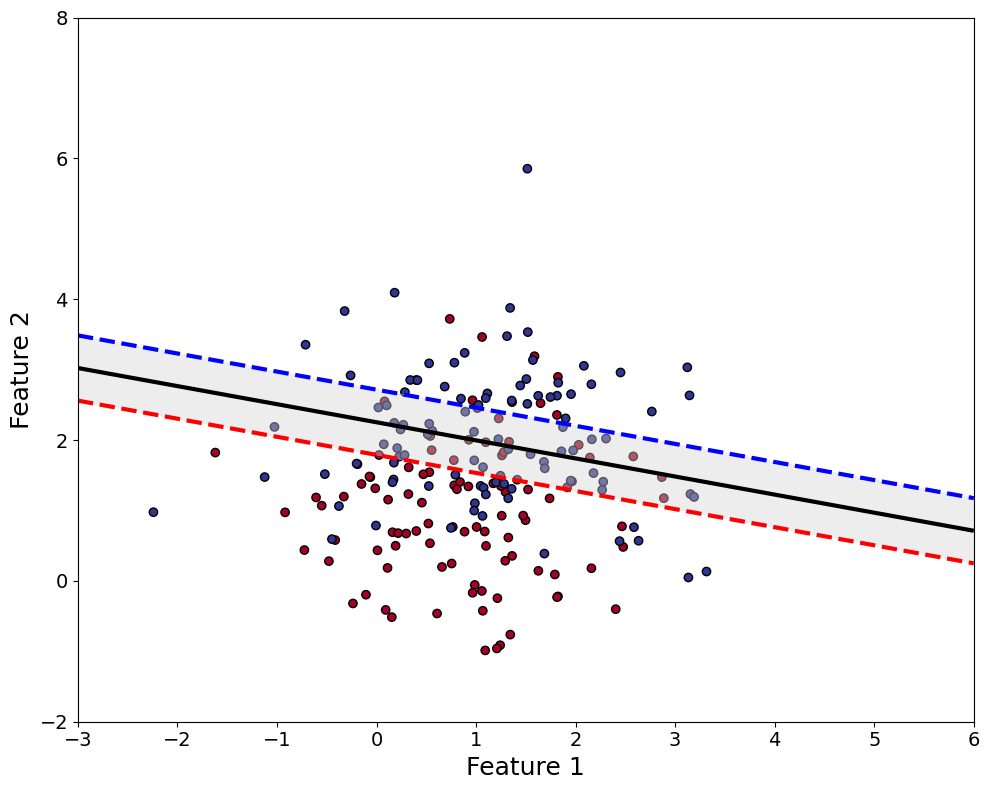

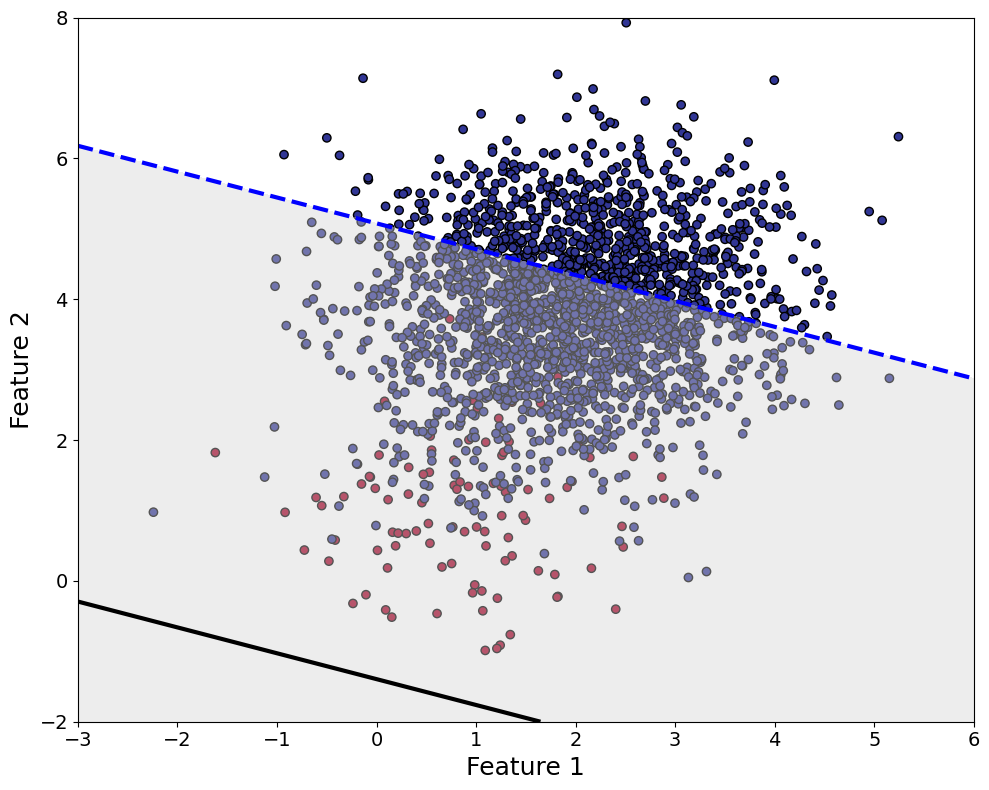

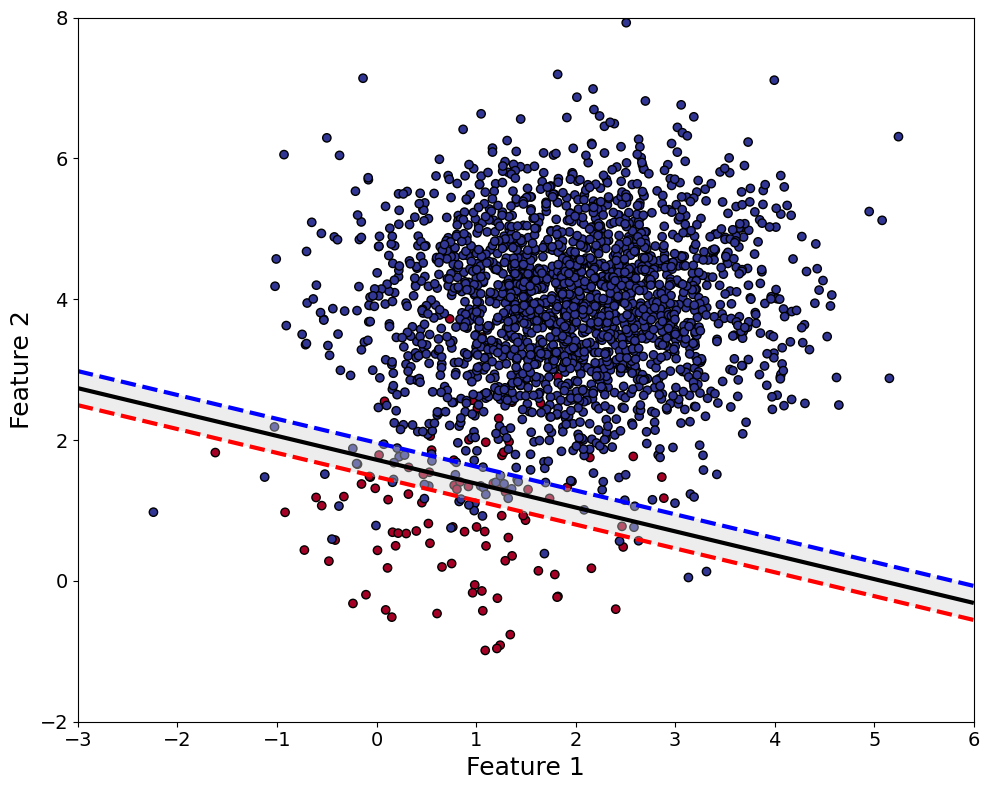

In [13]:
def plot_decision_contourlines(ax, model, X, y):
    global ticklabel_size, label_size
    global x_min, x_max
    global y_min, y_max
    
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black')
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    if isinstance(model, LinearRegression):
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    else:  # LogisticRegression
        Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    ax.contour(xx, yy, Z, levels=[0, 0.5, 1], colors=['r', 'k', 'b'], 
                   linestyles=['--', '-', '--'], linewidths=3)
        
    # Shade the region where 0 < y < 1
    ax.contourf(xx, yy, Z, levels=[0, 1], colors=['lightgray'], alpha=0.4)
    
    ax.set_xlabel('Feature 1', fontsize=label_size)
    ax.set_ylabel('Feature 2', fontsize=label_size)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
# Plot initial decision boundaries
fig, ax6 = plt.subplots(figsize=(10, 8))
plot_decision_contourlines(ax6, lr_model_init, X, y)
plt.tight_layout()
# plt.savefig('linear_contour_init.png', dpi=300)
plt.show()

fig, ax7 = plt.subplots(figsize=(10, 8))
plot_decision_contourlines(ax7, log_model_init, X, y)
plt.tight_layout()
# plt.savefig('logistic_contour_init.png', dpi=300)
plt.show()

# Plot updated decision boundaries
fig, ax8 = plt.subplots(figsize=(10, 8))
plot_decision_contourlines(ax8, lr_model_update, X_new, y_new)
plt.tight_layout()
# plt.savefig('linear_contour_update.png', dpi=300)
plt.show()

fig, ax9 = plt.subplots(figsize=(10, 8))
plot_decision_contourlines(ax9, log_model_update, X_new, y_new)
plt.tight_layout()
# plt.savefig('logistic_contour_update.png', dpi=300)
plt.show()

### 3.1.4 逻辑回归

构建Sigmoid函数，并画出Sigmoid函数的曲线

直观的展示如何建立线性回归函数和概率之间的联系

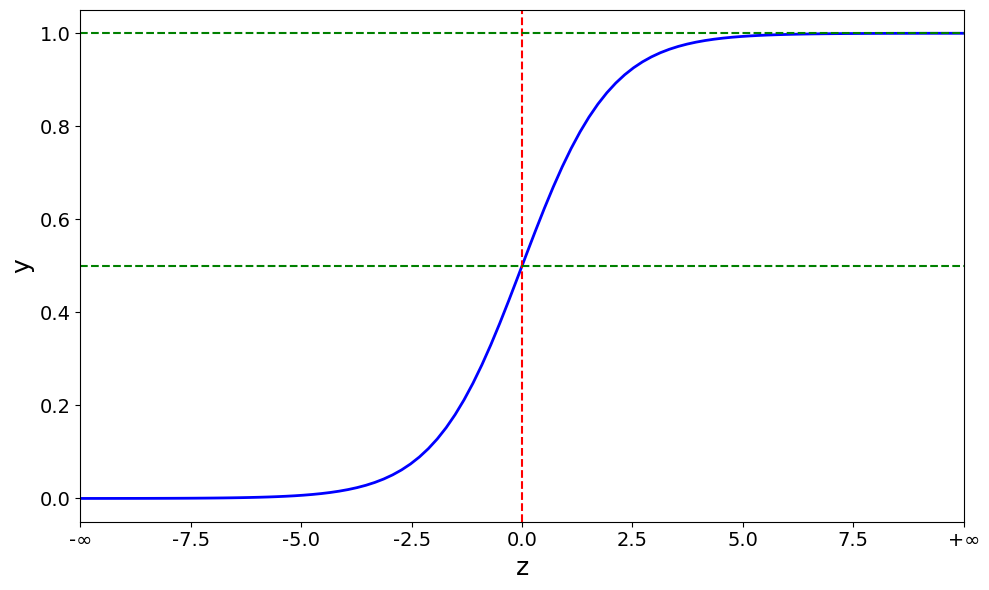

In [26]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Generate x values
x = np.linspace(-10, 10, 100)

# Calculate sigmoid values
y = sigmoid(x)

# Plot the sigmoid curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, 'b-', linewidth=2)
ax.set_xlabel('z', fontsize=label_size)
ax.set_ylabel('y', fontsize=label_size)

# Set x-ticks
xticks = np.arange(-10.0, 10.1, 2.5)
ax.set_xticks(xticks)

# Modify tick labels
xticklabels = ['-∞' if x == -10 else ('+∞' if x == 10 else str(x)) for x in xticks]
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

ax.set_xlim(-10, 10)
ax.set_ylim(-0.05, 1.05)

# Add vertical line at x=0
ax.axvline(x=0, color='r', linestyle='--')

# Add horizontal lines at y=0.5 and y=1
ax.axhline(y=0.5, color='g', linestyle='--')
ax.axhline(y=1, color='g', linestyle='--')

plt.tight_layout()
# plt.savefig('sigmoid_function.png', dpi=300)
plt.show()

### 3.1.5 使用逻辑回归识别手写字母"1"

构建二分类数据集

In [23]:
# Extract features and labels from trainset
x_train = []
y_train = []
for image, label in trainset:
    x_train.append(image.numpy())
    y_train.append(1 if label == 1 else 0)  # Set label to 1 for character 1, 0 otherwise

x_train = np.array(x_train)
y_train = np.array(y_train)

# Extract features and labels from trainset
x_test = []
y_test = []
for image, label in testset:
    x_test.append(image.numpy())
    y_test.append(1 if label == 1 else 0)  # Set label to 1 for character 1, 0 otherwise

x_test = np.array(x_test)
y_test = np.array(y_test)

定义Sigmoid分类函数和损失函数

In [24]:
# Define linear function
def linear(X, w, b):
    '''        
    Parameters:
    X (numpy array): Input features, shape (n_samples, n_features)
    w (numpy array): Weight vector, shape (n_features,)
    b (float): Bias term
    '''
    return np.dot(X, w) + b

# Define sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Define forward function
def forward(X, w, b):
    '''        
    Parameters:
    X (numpy array): Input features, shape (n_samples, n_features)
    w (numpy array): Weight vector, shape (n_features,)
    b (float): Bias term
    '''
    return sigmoid(linear(X, w, b))

# Predict probability function
def predict(X, w, b):
    y_proba = forward(X, w, b)
    y_pred = (y_proba >= 0.5).astype(int)
    return y_pred, y_proba

# Binary cross-entropy
def binary_cross_entropy(y, y_pred, eps=1e-15):
    return -(y * np.log(y_pred + eps) + (1 - y) * np.log(1 - y_pred + eps))
    
# Define compute_loss function
def compute_loss(X, y, w, b):
    """
    Compute the binary cross-entropy loss for logistic regression.
    
    Parameters:
    X (numpy array): Input features, shape (n_samples, n_features)
    y (numpy array): True labels, shape (n_samples,)
    w (numpy array): Weight vector, shape (n_features,)
    b (float): Bias term
    
    Returns:
    float: Average binary cross-entropy loss
    """    
    n = X.shape[0] # number of samples
    
    # Compute model predictions
    y_pred = forward(X, w, b)
    
    # Compute loss
    loss = 1/n * np.sum(binary_cross_entropy(y, y_pred))
    
    return loss

# Compute gradients
def compute_gradients(X, y, w, b):
    """
    Compute the gradients for logistic regression.
    
    Parameters:
    X (numpy array): Input features, shape (n_samples, n_features)
    y (numpy array): True labels, shape (n_samples,)
    w (numpy array): Weight vector, shape (n_features,)
    b (float): Bias term
    
    Returns:
    dw: gradients of weights
    db: gradients of bias
    """
    n = X.shape[0] # number of samples
    
    # Compute model predictions
    y_pred = forward(X, w, b)
    
    dw = 1/n * np.dot(X.T, (y_pred - y))
    db = 1/n * np.sum(y_pred - y)
    
    return dw, db

# Train logistic regression model
def train_logistic_regression(X, y, learning_rate=0.01, num_iterations=1000):
    """
    Compute the gradients for logistic regression.
    
    Parameters:
    X (numpy array): Input features, shape (n_samples, n_features)
    y (numpy array): True labels, shape (n_samples,)
    
    Returns:
    w: weights of logistic regression model
    b: bias of logistic regression model
    """
    eps = 1e-15
    _, ftr_num = X.shape
    
    w = np.zeros(ftr_num)
    b = 0.0
    
    # Initialize Adagrad accumulators
    lr_w = np.zeros(ftr_num)
    lr_b = 0.0
    
    for i in range(num_iterations):
        # Compute loss and gradients
        loss = compute_loss(X, y, w, b)
        dw, db = compute_gradients(X, y, w, b)
        
        # Update accumulators
        lr_w = dw ** 2
        lr_b = db ** 2
        
        # Update parameters
        w -= learning_rate / (np.sqrt(lr_w) + eps) * dw
        b -= learning_rate / (np.sqrt(lr_b) + eps) * db
        
        # Print loss every 100 iterations
        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss}")
    
    return w, b


用曲线图直观的展现损失函数的意义

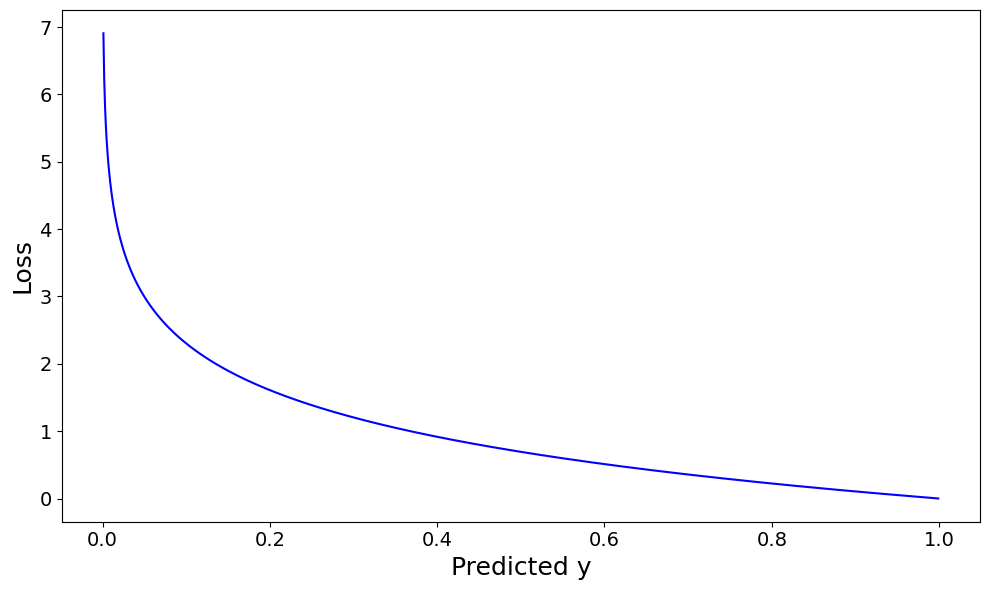

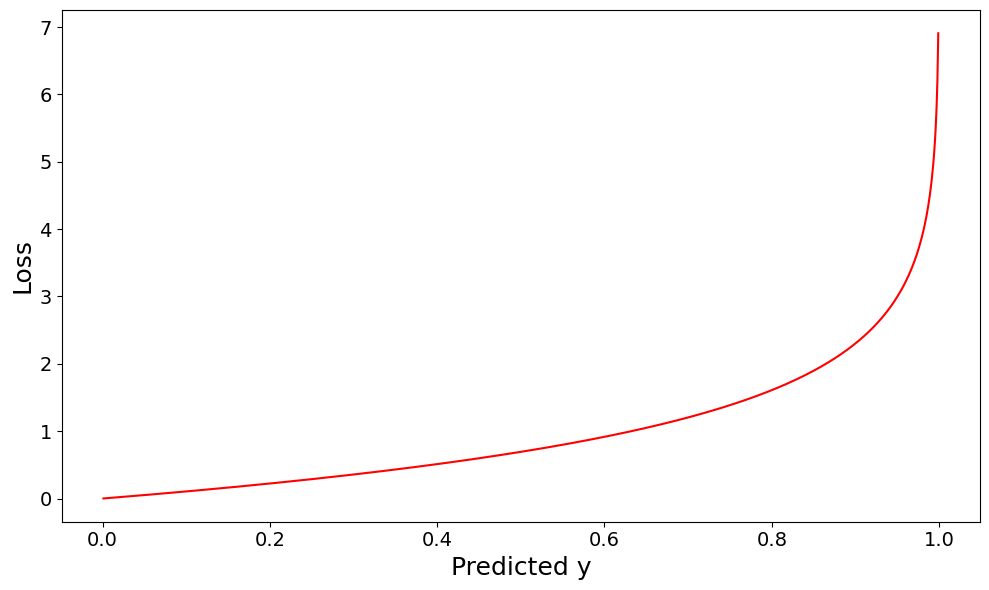

In [25]:
# Generate prediction values
y_pred = np.linspace(0.001, 0.999, 1000)

# Compute loss for y_true = 1 and y_true = 0
loss_y1 = binary_cross_entropy(1, y_pred)
loss_y0 = binary_cross_entropy(0, y_pred)

# Plotting
fig, ax_y1 = plt.subplots(figsize=(10, 6))
ax_y1.plot(y_pred, loss_y1, label='y_true = 1', color='blue')
ax_y1.set_xlabel('Predicted y', fontsize=label_size)
ax_y1.set_ylabel('Loss', fontsize=label_size)
ax_y1.tick_params(axis='both', which='major', labelsize=ticklabel_size)
plt.tight_layout()
plt.savefig('binary_cross_entropy_loss1.png', dpi=300)
plt.show()

# Plotting
fig, ax_y0 = plt.subplots(figsize=(10, 6))
plt.plot(y_pred, loss_y0, label='y_true = 0', color='red')
ax_y0.set_xlabel('Predicted y', fontsize=label_size)
ax_y0.set_ylabel('Loss', fontsize=label_size)
ax_y0.tick_params(axis='both', which='major', labelsize=ticklabel_size)
plt.tight_layout()
plt.savefig('binary_cross_entropy_loss0.png', dpi=300)
plt.show()

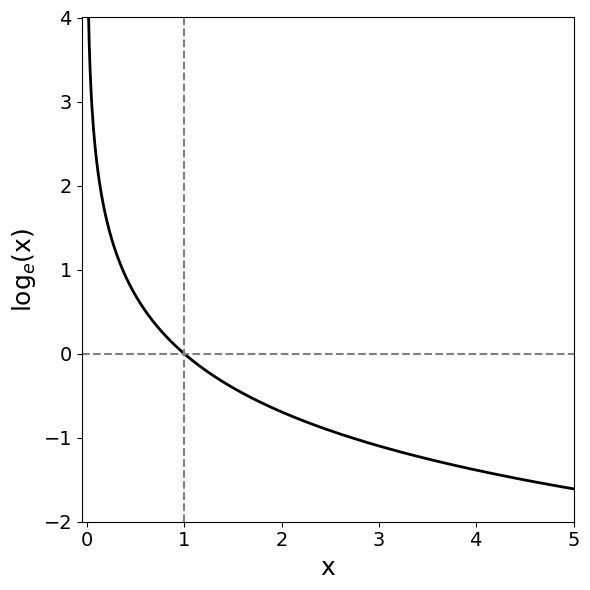

In [26]:
# Generate x values
x = np.linspace(0.01, 5, 1000)

# Compute natural logarithm
y = -np.log(x)

# Create the plot
fig, ax_log = plt.subplots(figsize=(6, 6))

ax_log.plot(x, y, label='ln(x)', color='k', linewidth=2)

ax_log.set_xlabel('x', fontsize=label_size)
ax_log.set_ylabel('log$_e$(x)', fontsize=label_size)
ax_log.tick_params(axis='both', which='major', labelsize=ticklabel_size)

ax_log.set_xlim(-0.05, 5)
ax_log.set_ylim(-2, 4)
# Add vertical line at x=1
ax_log.axvline(x=1, color='gray', linestyle='--')

# Add horizontal line at y=0
ax_log.axhline(y=0, color='gray', linestyle='--')

plt.tight_layout()
# plt.savefig('natural_logarithm_function.png', dpi=300)
plt.show()

训练逻辑回归模型

In [27]:
# Train the model
w, b = train_logistic_regression(x_train, y_train)

y_pred, y_proba = predict(x_test, w, b)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

Iteration 0, Loss: 0.6931471805599435
Iteration 100, Loss: 0.12422293332655861
Iteration 200, Loss: 0.10062522295557218
Iteration 300, Loss: 0.09299181897738767
Iteration 400, Loss: 0.08809407647531457
Iteration 500, Loss: 0.08451829392045176
Iteration 600, Loss: 0.0825571422250939
Iteration 700, Loss: 0.08106430367062357
Iteration 800, Loss: 0.08001654373457909
Iteration 900, Loss: 0.07926216748886451
Precision: 0.9287, Recall: 0.8493, Accuracy: 0.9755, F1-Score: 0.8873


案例演示：随机选取图片，输出判断结果

Sample 1: imgDisp label is 1, x label is 1


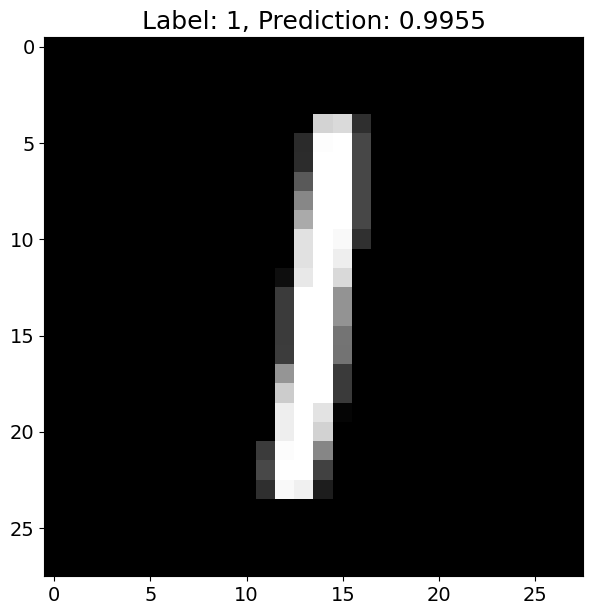

Sample 2: imgDisp label is 6, x label is 0


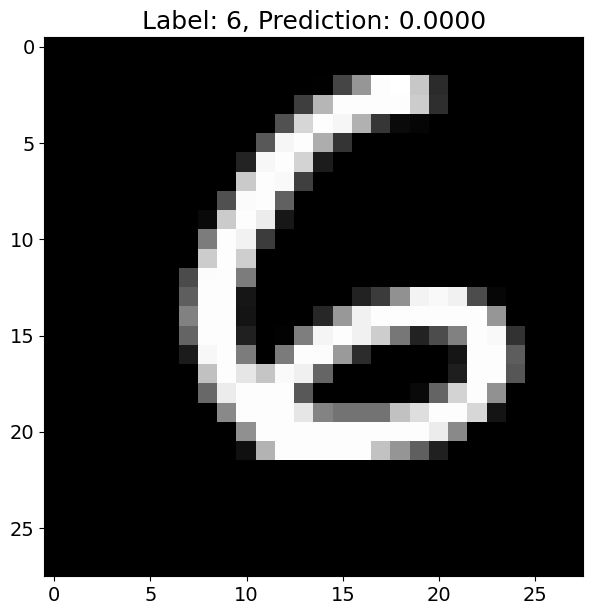

Sample 3: imgDisp label is 2, x label is 0


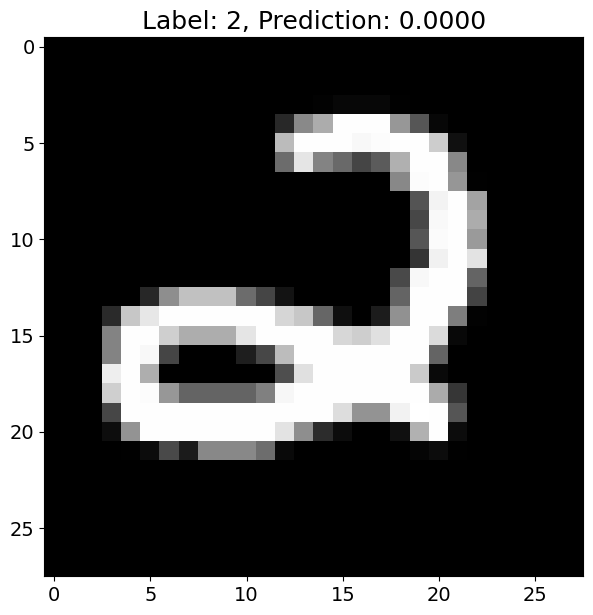

In [28]:
# Random select 3 examples from imgDisp and testset
np.random.seed(42)
idx = np.random.choice(len(imgDisp), 3)

# Select instances
imgDisp_select = [imgDisp[i] for i in idx]
x_select = x_test[idx]
y_select = y_test[idx]

y_select_pred, y_select_proba = predict(x_select, w, b)

# Check the selected instances' labels are the same
for i in range(len(idx)):
    print(f'Sample {i+1}: imgDisp label is {imgDisp_select[i][1]}, x label is {y_select[i]}')

    # Display image from imgDisp
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(imgDisp_select[i][0], cmap='gray')
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
    ax.set_title(f"Label: {imgDisp_select[i][1]}, Prediction: {y_select_proba[i]:.4f}", fontsize=label_size)

    # plt.savefig(f'binary_prediction_{i+1}.png', dpi=300) # Make figure clearer
    plt.show()

## 3.2 常用的二分类模型——支持向量机

### 3.2.1 支持向量机的基本逻辑

In [29]:
# Define SVM classifier
mdl_svm = svm.SVC(kernel='linear', probability=True)

# Train model
start_time = time.time()
mdl_svm.fit(x_train, y_train)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

Training time: 236.53 seconds


In [30]:
# Make predictions and evaluate the model
y_pred_svm = mdl_svm.predict(x_test)
y_proba_svm = mdl_svm.predict_proba(x_test) # Output ratio

accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

Precision: 0.9755, Recall: 0.9454, Accuracy: 0.9911, F1-Score: 0.9602


## 3.3 常用的二分类模型——决策树和随机森林

In [31]:
# Define DecisionTree classifier
mdl_dt = tree.DecisionTreeClassifier()

# Train model
start_time = time.time()
mdl_dt.fit(x_train, y_train)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

# Define Random Forest classifier
mdl_rf = RandomForestClassifier(n_estimators=100)

# Train model
start_time = time.time()
mdl_rf.fit(x_train, y_train)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

Training time: 10.80 seconds
Training time: 50.58 seconds


In [32]:
y_pred_dt = mdl_dt.predict(x_test)
y_proba_dt = mdl_dt.predict_proba(x_test) # Output ratio

accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

y_pred_rf = mdl_rf.predict(x_test)
y_proba_rf = mdl_rf.predict_proba(x_test) # Output ratio

accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

Precision: 0.9123, Recall: 0.9251, Accuracy: 0.9814, F1-Score: 0.9186
Precision: 0.9897, Recall: 0.9348, Accuracy: 0.9915, F1-Score: 0.9615


# 实验五：分类模型的评估方法
## 3.4 二分类模型的度量

准确率、召回率、敏感性、特异性、精确度、F1-Score

In [35]:
def cls_counts(y_test, y_proba, th=0.5):
    y_pred = (y_proba > th).astype(int)

    tp_idx = (y_test == 1) & (y_pred == 1)
    fp_idx = (y_test == 0) & (y_pred == 1)
    tn_idx = (y_test == 0) & (y_pred == 0)
    fn_idx = (y_test == 1) & (y_pred == 0)

    tp = np.sum(tp_idx)
    fp = np.sum(fp_idx)
    tn = np.sum(tn_idx)
    fn = np.sum(fn_idx)

    return th, (tp, fp, tn, fn)

th, (tp, fp, tn, fn) = cls_counts(y_test, y_proba)
print(f'Threshold {th}, TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')

Threshold 0.5, TP: 964, FP: 74, TN: 8791, FN: 171


Precision: 0.9287, Recall (Sensitivity): 0.8493, Specificity: 0.9917, Accuracy: 0.9755, F1-Score: 0.8873


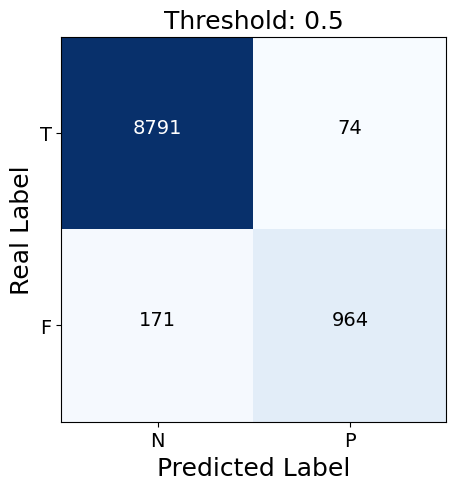

In [38]:
def plot_confusion_matrix(th, tp, fp, tn, fn):
    """Plots a confusion matrix given the number of true positives, false positives,
    true negatives, and false negatives."""
    global label_size, ticklabel_size # Set global variables of font size

    cm = np.array([[tn, fp], [fn, tp]])

    # Display the confusion matrix as a heatmap
    fig, ax = plt.subplots(figsize=(5,5))
    img = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Add labels to the axes
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks, ['N', 'P'], fontsize=ticklabel_size)
    ax.set_yticks(tick_marks, ['T', 'F'], fontsize=ticklabel_size)

    # Add the count of each category to the plot
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     fontsize=ticklabel_size,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size

    ax.set_ylabel('Real Label', fontsize=label_size)
    ax.set_xlabel('Predicted Label', fontsize=label_size)
    ax.set_title(f'Threshold: {th}', fontsize=label_size)

    return fig, ax

def get_scores(tp, fp, tn, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn) # Also called sensitivity
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    f1 = 2 * precision * recall / (precision + recall)

    specificity = tn / (tn + fp)

    return precision, recall, specificity, accuracy, f1

precision, recall, specificity, accuracy, f1 = get_scores(tp, fp, tn, fn)
print(f'Precision: {precision:.4f}, Recall (Sensitivity): {recall:.4f}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

# Example usage (replace with your actual values)
fig, ax = plot_confusion_matrix(th, tp, fp, tn, fn)

# plt.savefig(f'binary_confusion_matrix.png', dpi=300) # Make figure clearer
plt.show()

Precision: 0.6242, Recall (Sensitivity): 0.9674, Specificity: 0.9254, Accuracy: 0.9302, F1-Score: 0.7588


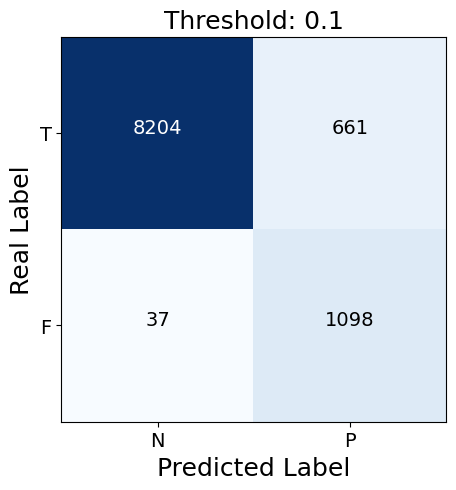

In [39]:
th = 0.1
th, (tp, fp, tn, fn) = cls_counts(y_test, y_proba, th)

precision, recall, specificity, accuracy, f1 = get_scores(tp, fp, tn, fn)
print(f'Precision: {precision:.4f}, Recall (Sensitivity): {recall:.4f}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

fig, ax = plot_confusion_matrix(th, tp, fp, tn, fn)
# plt.savefig(f'binary_confusion_matrix_0D1.png', dpi=300) # Make figure clearer
plt.show()

Precision: 0.9954, Recall (Sensitivity): 0.5736, Specificity: 0.9997, Accuracy: 0.9513, F1-Score: 0.7278


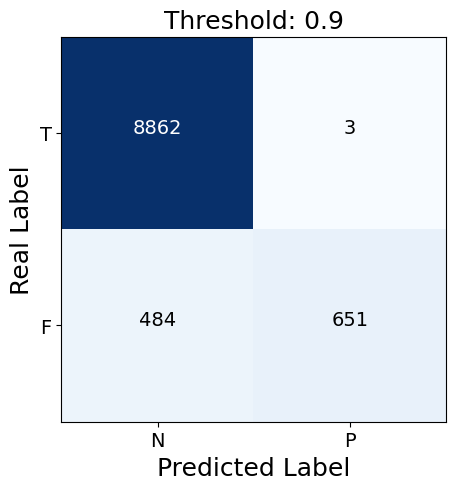

In [40]:
th = 0.9
th, (tp, fp, tn, fn) = cls_counts(y_test, y_proba, th)

precision, recall, specificity, accuracy, f1 = get_scores(tp, fp, tn, fn)
print(f'Precision: {precision:.4f}, Recall (Sensitivity): {recall:.4f}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

fig, ax = plot_confusion_matrix(th, tp, fp, tn, fn)
# plt.savefig(f'binary_confusion_matrix_0D9.png', dpi=300) # Make figure clearer
plt.show()

ROC（Receiver operating characteristic curve）接收者操作特征曲线

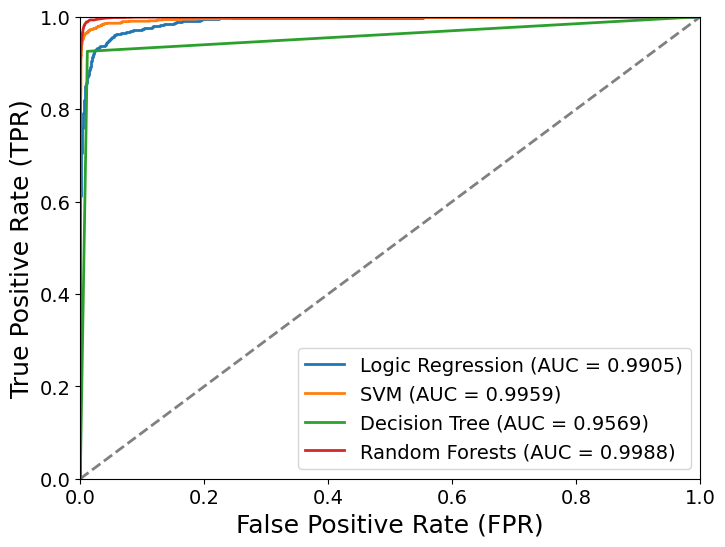

In [41]:
def plot_roc_curve_base():
    """Plots the ROC curve and computes AUC."""
    global label_size, ticklabel_size # Set global variables of font size

    fig, ax = plt.subplots(figsize=(8,6))

    ax.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size

    ax.set_xlabel('False Positive Rate (FPR)', fontsize=label_size)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=label_size)

    return fig, ax

def add_roc_curve(ax, y_true, y_proba, curve_color, curve_label):
    """Plots the ROC curve and computes AUC."""

    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    roc = ax.plot(fpr, tpr, color=curve_color, lw=2, label=f'{curve_label} (AUC = {roc_auc:.4f})')

    return roc_auc, fpr, tpr, thresholds

fig, ax = plot_roc_curve_base()

roc_auc_logic, fpr_logic, tpr_logic, thresholds_logic = add_roc_curve(ax, y_test, y_proba, color_list[0], 'Logic Regression')
roc_auc_logic, fpr_logic, tpr_logic, thresholds_logic = add_roc_curve(ax, y_test, y_proba_svm[:,1], color_list[1], 'SVM')
roc_auc_logic, fpr_logic, tpr_logic, thresholds_logic = add_roc_curve(ax, y_test, y_proba_dt[:,1], color_list[2], 'Decision Tree')
roc_auc_logic, fpr_logic, tpr_logic, thresholds_logic = add_roc_curve(ax, y_test, y_proba_rf[:,1], color_list[3], 'Random Forests')

plt.legend(loc="lower right", fontsize=ticklabel_size)
# plt.savefig(f'binary_roc_curve.png', dpi=300) # Make figure clearer
plt.show()


## 3.5 由二分类到多分类

In [42]:
# Extract features and labels from trainset
x_train = []
y_train = []
for image, label in trainset:
    x_train.append(image.numpy())
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

# Extract features and labels from trainset
x_test = []
y_test = []
for image, label in testset:
    x_test.append(image.numpy())
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

3.5.1 一对多（One-vs-Rest）方法

In [43]:
# Define logic multi-classifier
mdl_logic_ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Train model
start_time = time.time()
mdl_logic_ovr.fit(x_train, y_train)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

# Make predictions and evaluate the model
y_pred_logic_ovr = mdl_logic_ovr.predict(x_test)
y_proba_logic_ovr = mdl_logic_ovr.predict_proba(x_test) # Output ratio

accuracy = accuracy_score(y_test, y_pred_logic_ovr)
print(f'Accuracy: {accuracy:.4f}')

Training time: 6.83 seconds
Accuracy: 0.8535


In [44]:
# Get class list: 0, 1, ..., 9
class_list = np.sort(np.unique(y_train))

# Create model list
mdl_logic_list = []
for c in class_list:
    mdl_logic_list.append(LogisticRegression(max_iter=1000))

# Train models seperately
for i in range(len(class_list)):
    start_time = time.time()
    mdl_logic_list[i].fit(x_train, (y_train == class_list[i]).astype(int))
    end_time = time.time()
    print(f'Training class {class_list[i]}, Training time: {end_time - start_time:.2f} seconds')

Training class 0, Training time: 0.67 seconds
Training class 1, Training time: 0.50 seconds
Training class 2, Training time: 0.71 seconds
Training class 3, Training time: 0.69 seconds
Training class 4, Training time: 0.52 seconds
Training class 5, Training time: 0.81 seconds
Training class 6, Training time: 0.49 seconds
Training class 7, Training time: 0.48 seconds
Training class 8, Training time: 0.98 seconds
Training class 9, Training time: 0.68 seconds


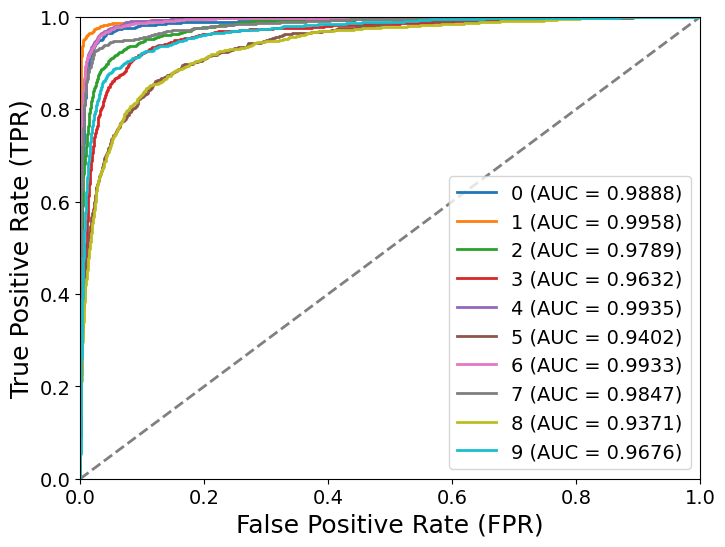

In [45]:
# Plot ROC curve
fig, ax = plot_roc_curve_base()

# Draw ROC of individual classifier
for i in range(len(class_list)):
    # Make predictions and evaluate the model
    y_test_trans = (y_test == class_list[i]).astype(int)
    y_proba = mdl_logic_list[i].predict_proba(x_test) # Output ratio

    roc_auc_logic, fpr_logic, tpr_logic, thresholds_logic = add_roc_curve(ax, y_test_trans, y_proba[:,1], color_list[i], f'{class_list[i]}')

plt.legend(loc="lower right", fontsize=ticklabel_size)
# plt.savefig(f'binary_roc_curve_ovr.png', dpi=300) # Make figure clearer
plt.show()

Sample 1: imgDisp label is 9, testset label is 9, predict label is 9
Sample 2: imgDisp label is 2, testset label is 2, predict label is 0
Sample 3: imgDisp label is 2, testset label is 2, predict label is 2
Sample 4: imgDisp label is 9, testset label is 9, predict label is 8
Sample 5: imgDisp label is 8, testset label is 8, predict label is 8
Sample 6: imgDisp label is 5, testset label is 5, predict label is 5
Sample 7: imgDisp label is 7, testset label is 7, predict label is 7
Sample 8: imgDisp label is 7, testset label is 7, predict label is 7
Sample 9: imgDisp label is 4, testset label is 4, predict label is 4
Sample 10: imgDisp label is 5, testset label is 5, predict label is 5


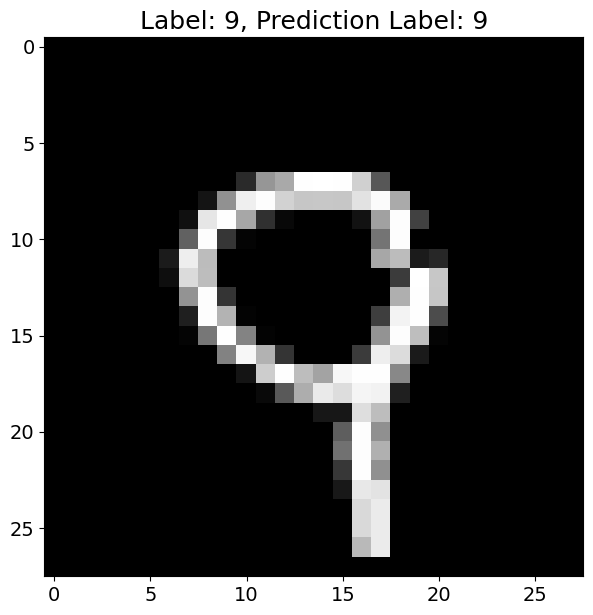

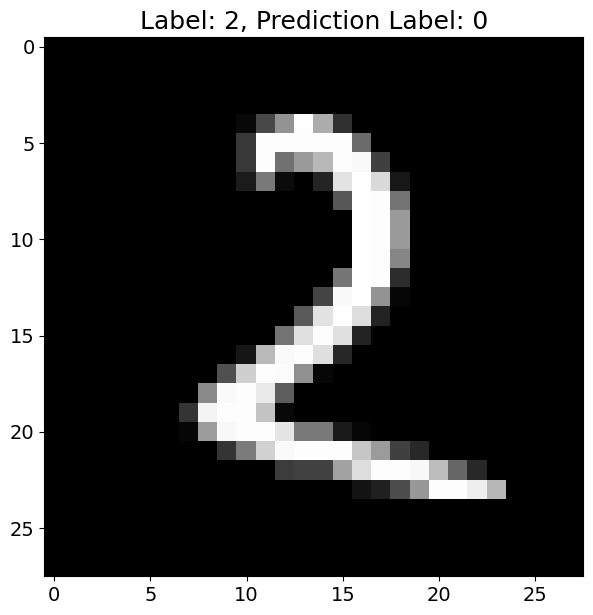

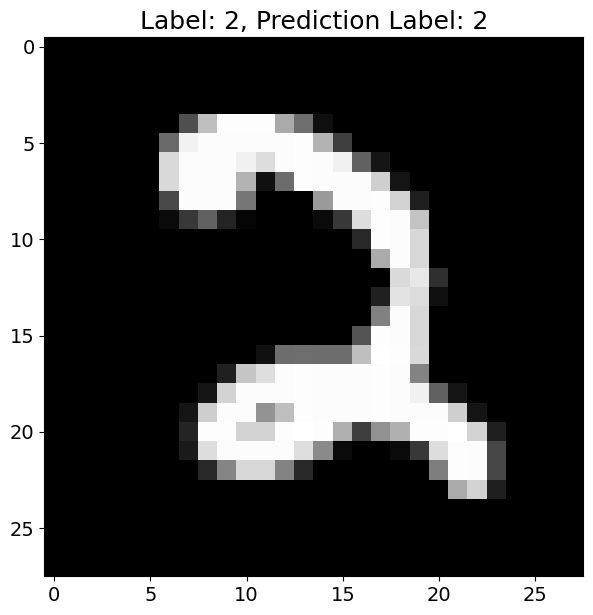

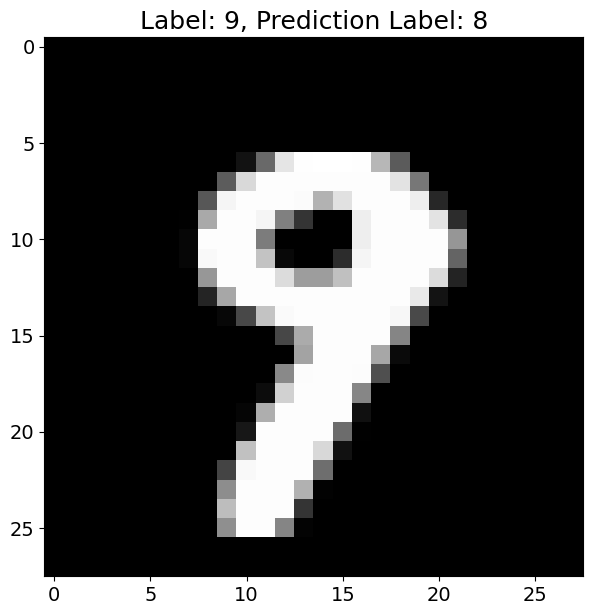

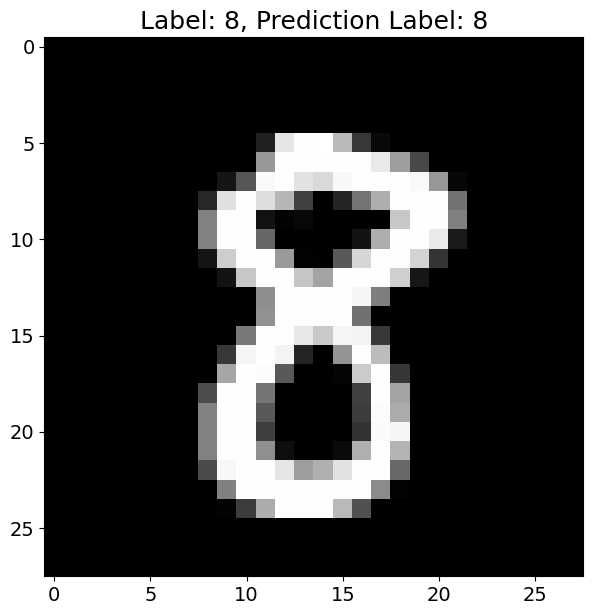

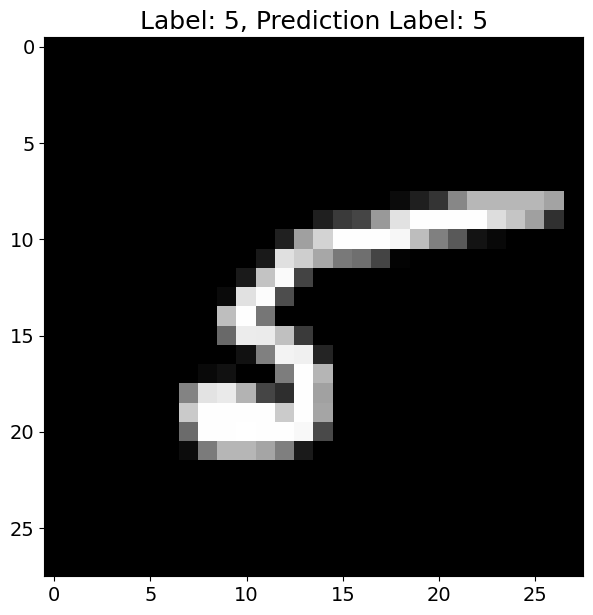

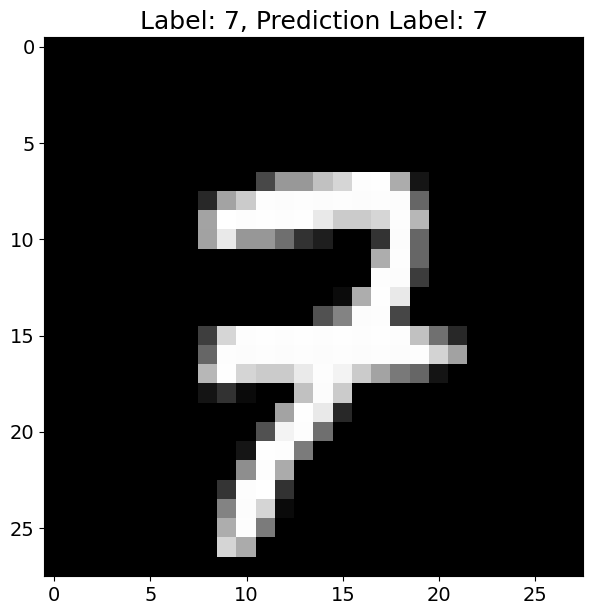

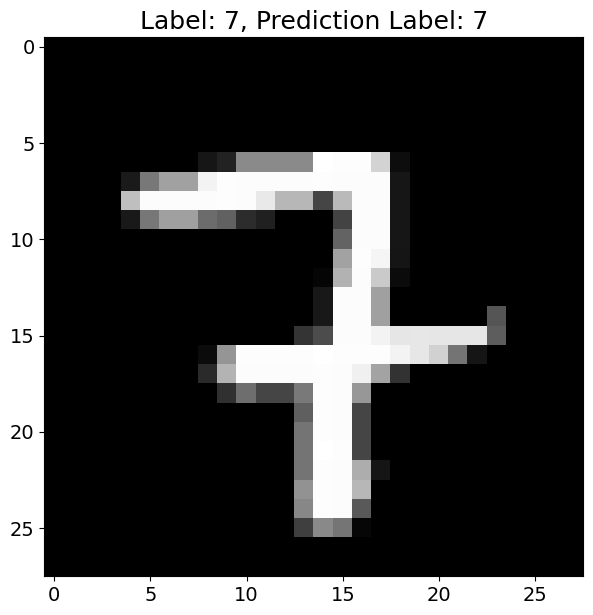

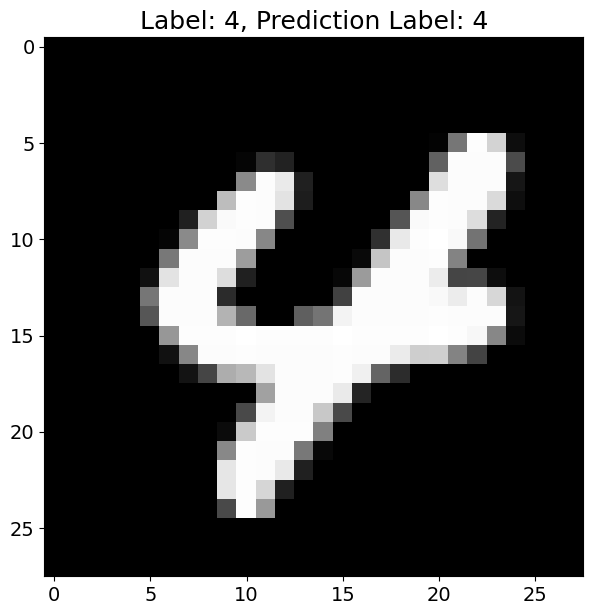

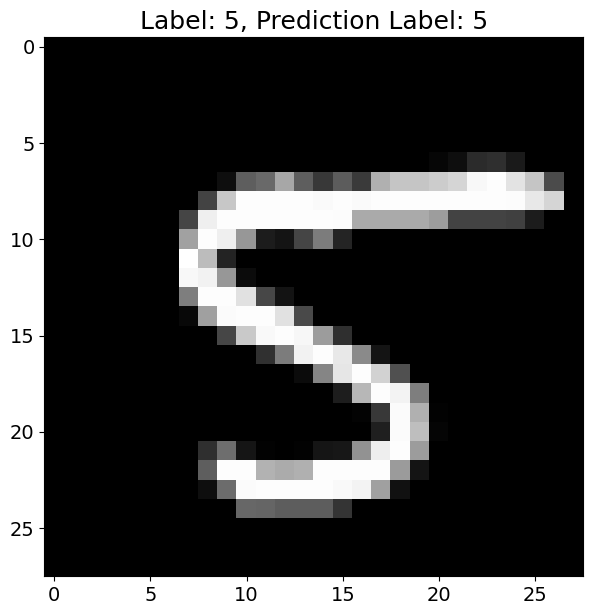

In [46]:
sample_num = 10

# Random select 3 examples from imgDisp and testset
np.random.seed(1)
idx = np.random.choice(len(imgDisp), sample_num)

# Select instances
imgDisp_select = [imgDisp[i] for i in idx]
testset_select = [testset[i] for i in idx]

# Check the selected instances' labels are the same
for i in range(sample_num):
    x = testset_select[i][0].view(-1, input_size)

    # Using model to predict character
    y_pred_list = []
    for j in range(len(mdl_logic_list)):
        y_pred_list.append(mdl_logic_list[j].predict(x))

    y_pred = np.argmax(np.array(y_pred_list), axis=0)[0]

    # Display image from imgDisp
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(imgDisp_select[i][0], cmap='gray')
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
    ax.set_title(f"Label: {imgDisp_select[i][1]}, Prediction Label: {y_pred}", fontsize=label_size)

    print(f'Sample {i+1}: imgDisp label is {imgDisp_select[i][1]}, testset label is {testset_select[i][1]}, predict label is {y_pred}')

In [47]:
# Prediction
y_pred_list = []
for i in range(len(mdl_logic_list)):
    y_pred_list.append(mdl_logic_list[i].predict(x_test))

y_pred = np.argmax(np.array(y_pred_list), axis=0)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7566


混淆矩阵

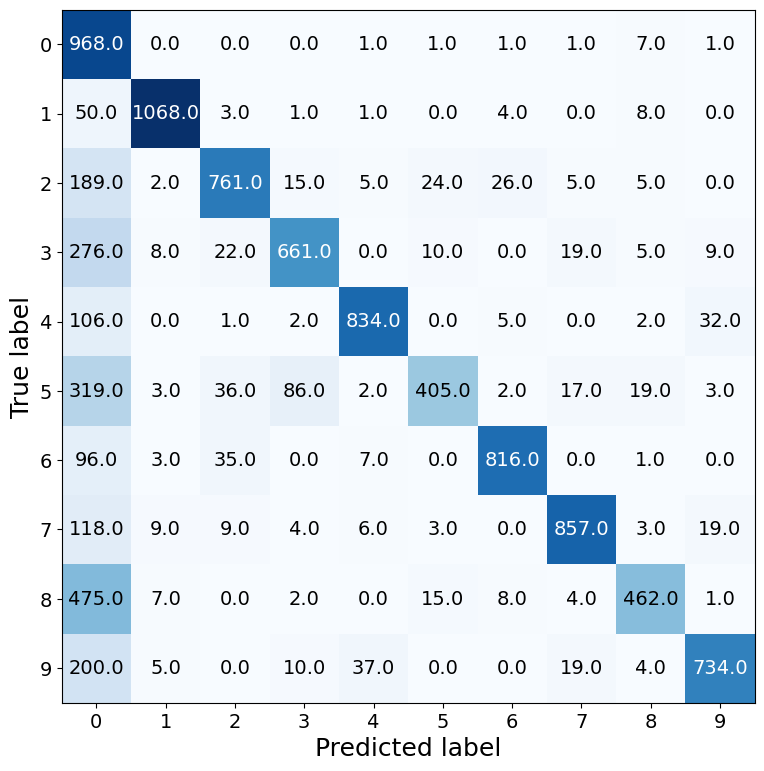

In [48]:
# Create confusion matrix
cm_test = np.zeros((10, 10))
for i in range(len(y_test)):
    cm_test[y_test[i], y_pred[i]] += 1

# Display confusion matrix
fig, ax = plt.subplots(figsize=(9,9))
im = ax.imshow(cm_test, cmap=plt.cm.Blues, interpolation='nearest')

# Loop over data dimensions and create text annotations.
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        ax.text(j, i, cm_test[i, j], fontsize=ticklabel_size, ha="center", va="center",
                color="white" if cm_test[i, j] > cm_test.max() / 2. else "black")

ax.set_xlabel('Predicted label', fontsize=label_size)
ax.set_ylabel('True label', fontsize=label_size)

ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(10))

ax.set_yticks(np.arange(10))
ax.set_yticklabels(np.arange(10))

ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

# plt.savefig(f'confusion_matrix_numel.png', dpi=300) # Make figure clearer

plt.show()

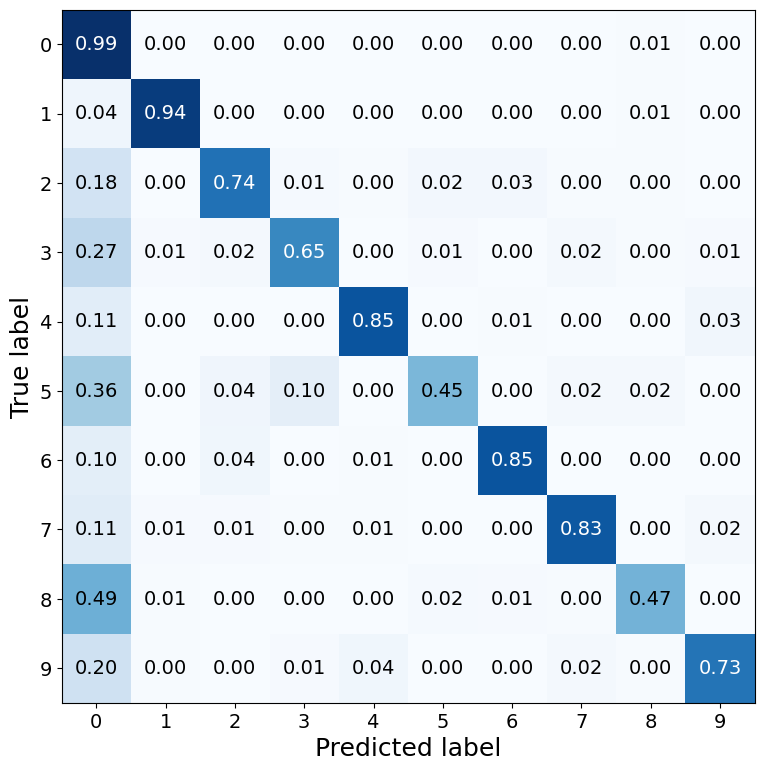

In [49]:
# Create confusion matrix
cm_test = np.zeros((10, 10))
for i in range(len(y_test)):
    cm_test[y_test[i], y_pred[i]] += 1

# Change value to ratio
cm_test = cm_test / np.sum(cm_test, axis=1, keepdims=True)

# Display confusion matrix
fig, ax = plt.subplots(figsize=(9,9))
im = ax.imshow(cm_test, cmap=plt.cm.Blues, interpolation='nearest')

# Loop over data dimensions and create text annotations.
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        ax.text(j, i, format(cm_test[i, j], '.2f'), fontsize=ticklabel_size, ha="center", va="center",
                color="white" if cm_test[i, j] > cm_test.max() / 2. else "black")

ax.set_xlabel('Predicted label', fontsize=label_size)
ax.set_ylabel('True label', fontsize=label_size)

ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(10))

ax.set_yticks(np.arange(10))
ax.set_yticklabels(np.arange(10))

ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

# plt.savefig(f'confusion_matrix_ratio.png', dpi=300) # Make figure clearer

plt.show()

3.5.2 一对一（One-vs-One）方法

In [50]:
# Define logic regression classifier
mdl_logic_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))

# Train model
start_time = time.time()
mdl_logic_ovo.fit(x_train, y_train)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

# Make predictions and evaluate the model
y_pred = mdl_logic_ovo.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Training time: 4.39 seconds
Accuracy: 0.8778


In [51]:
# Get class list: 0, 1, ..., 9
class_list = np.sort(np.unique(y_train))

# Create model matrix to save models
mdl_logic_matrix = {}
for cls_p in class_list:
    mdl_logic_matrix[cls_p] = {}
    for cls_n in class_list:
        if cls_p == cls_n:
            continue
        mdl_logic_matrix[cls_p][cls_n] = LogisticRegression(max_iter=1000)

for cls_p in class_list:
    # Training data of positive class
    x_train_ovo_p = x_train[(y_train == cls_p), :]
    y_train_ovo_p = np.ones(x_train_ovo_p.shape[0])

    # Testing data of positive class
    x_test_ovo_p = x_test[(y_test == cls_p), :]
    y_test_ovo_p = np.ones(x_test_ovo_p.shape[0])

    for cls_n in class_list:
        if cls_p == cls_n:
            continue

        # Training data of negative class
        x_train_ovo_n = x_train[(y_train == cls_n), :]
        y_train_ovo_n = np.zeros(x_train_ovo_n.shape[0])

        # Testing data of negative class
        x_test_ovo_n = x_test[(y_test == cls_n), :]
        y_test_ovo_n = np.zeros(x_test_ovo_n.shape[0])

        # Concatenate data for training
        x_train_ovo = np.concatenate((x_train_ovo_p, x_train_ovo_n), axis=0)
        y_train_ovo = np.concatenate((y_train_ovo_p, y_train_ovo_n), axis=0)

        # Model training
        start_time = time.time()
        mdl_logic_matrix[cls_p][cls_n].fit(x_train_ovo, y_train_ovo)
        end_time = time.time()

        # Concatenate data for testing
        x_test_ovo = np.concatenate((x_test_ovo_p, x_test_ovo_n), axis=0)
        y_test_ovo = np.concatenate((y_test_ovo_p, y_test_ovo_n), axis=0)

        # Test model on sub-task
        y_proba_ovo = mdl_logic_matrix[cls_p][cls_n].predict_proba(x_test_ovo) # Output ratio

        # Display results
        _, (tp, fp, tn, fn) = cls_counts(y_test_ovo, y_proba_ovo[:, 1])
        precision, recall, specificity, accuracy, f1 = get_scores(tp, fp, tn, fn)
        print(f'Training class {cls_p} ({x_train_ovo_p.shape[0]}) vs class {cls_n} ({x_train_ovo_n.shape[0]}), Training time: {end_time - start_time:.2f} seconds, Precision: {precision:.4f}, Recall (Sensitivity): {recall:.4f}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

Training class 0 (5923) vs class 1 (6742), Training time: 0.06 seconds, Precision: 0.9908, Recall (Sensitivity): 0.9929, Specificity: 0.9921, Accuracy: 0.9924, F1-Score: 0.9918
Training class 0 (5923) vs class 2 (5958), Training time: 0.08 seconds, Precision: 0.9819, Recall (Sensitivity): 0.9939, Specificity: 0.9826, Accuracy: 0.9881, F1-Score: 0.9878
Training class 0 (5923) vs class 3 (6131), Training time: 0.07 seconds, Precision: 0.9929, Recall (Sensitivity): 0.9939, Specificity: 0.9931, Accuracy: 0.9935, F1-Score: 0.9934
Training class 0 (5923) vs class 4 (5842), Training time: 0.08 seconds, Precision: 0.9959, Recall (Sensitivity): 0.9898, Specificity: 0.9959, Accuracy: 0.9929, F1-Score: 0.9928
Training class 0 (5923) vs class 5 (5421), Training time: 0.05 seconds, Precision: 0.9698, Recall (Sensitivity): 0.9837, Specificity: 0.9664, Accuracy: 0.9754, F1-Score: 0.9767
Training class 0 (5923) vs class 6 (5918), Training time: 0.06 seconds, Precision: 0.9828, Recall (Sensitivity): 0.

In [52]:
# Select class 1
x_test_select = x_test[:, :]

# Prediction
y_pred_counts = np.zeros((x_test_select.shape[0], len(class_list)))

for cls_p in class_list:
    for cls_n in class_list:
        if cls_p == cls_n:
            continue

        y_pred_counts[:, cls_p] = y_pred_counts[:, cls_p] + mdl_logic_matrix[cls_p][cls_n].predict(x_test_select)

y_pred = np.argmax(y_pred_counts, axis=1)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8783


3.5.3 Softmax回归

In [53]:
mdl_softmax = LogisticRegression(max_iter=1000, solver='lbfgs')

start_time = time.time()
mdl_softmax.fit(x_train, y_train)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

# Evaluate accuracy (or other metrics)
y_pred = mdl_softmax.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Training time: 8.71 seconds
Accuracy: 0.8739


In [54]:
# One-hot encoding
def one_hot_encode(y, num_classes):
    """Converts integer labels to one-hot encoding."""
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

# Example usage:
num_classes = len(class_list)
y_train_onehot = one_hot_encode(y_train, num_classes)

# Display one-hot encoding results of ten random sample
for _ in range(10):
    idx = np.random.randint(0, y_train_onehot.shape[0])

    print(f'Sample {idx+1},\t Class {y_train[idx]}: {y_train_onehot[idx,:]}')

Sample 32026,	 Class 3: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Sample 58547,	 Class 0: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample 54549,	 Class 9: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Sample 21759,	 Class 7: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Sample 45414,	 Class 8: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Sample 35731,	 Class 8: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Sample 51669,	 Class 8: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Sample 8445,	 Class 7: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Sample 19947,	 Class 6: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Sample 37533,	 Class 2: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [55]:
# Softmax function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Cross-entropy loss
def cross_entropy_loss(y, y_pred):
    """Compute cross-entropy loss."""
    epsilon = 1e-15  # Small value to avoid log(0)
    loss = -np.sum(y * np.log(y_pred + epsilon)) / y.shape[0]
    return loss

def gradient_descent(x, y, learning_rate, num_iterations):
    """Performs gradient descent optimization."""
    num_samples, num_features = x.shape
    num_classes = y.shape[1]

    # Initialize weights and bias
    w = np.random.randn(num_features, num_classes)
    b = np.zeros(num_classes)
    
    # Initialize Adagrad accumulators
    lr_w = np.zeros(w.shape)
    lr_b = 0.0

    for i in range(num_iterations):
        # Forward pass
        scores = np.dot(x, w) + b
        y_pred = softmax(scores)

        # Compute loss
        loss = cross_entropy_loss(y, y_pred)

        # Backward pass (compute gradients)
        dw = (1 / num_samples) * np.dot(x.T, (y_pred - y))
        db = (1 / num_samples) * np.sum(y_pred - y, axis=0)

        # Accumulate gradients
        lr_w += dw ** 2
        lr_b += db ** 2
        
        # Update parameters
        w -= learning_rate / np.sqrt(lr_w) * dw
        b -= learning_rate / np.sqrt(lr_b) * db

        if i % 100 == 0:
            print(f'Iteration {i}, Loss: {loss}')

    return w, b

def predict(x, w, b):
    """Predicts class labels for input data."""
    scores = np.dot(x, w) + b
    y_pred = softmax(scores)
    return np.argmax(y_pred, axis=1)

In [56]:
y_exp = np.array([0, 0, 1])
y_exp_pred = np.array([0.22, 0.28, 0.50])
print(cross_entropy_loss(y_exp, y_exp_pred))

0.23104906018664775


In [57]:
# Perform gradient descent
start_time = time.time()
w, b = gradient_descent(x_train, y_train_onehot, learning_rate=1, num_iterations=1000)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

# Make predictions
y_pred = predict(x_test, w, b)

# Evaluate accuracy (or other metrics)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Iteration 0, Loss: 5.870746553998726
Iteration 100, Loss: 0.7367843650888808
Iteration 200, Loss: 0.654928532243993
Iteration 300, Loss: 0.615790582660668
Iteration 400, Loss: 0.591133078629585
Iteration 500, Loss: 0.5733747452082254
Iteration 600, Loss: 0.5595571413043979
Iteration 700, Loss: 0.5482648360040003
Iteration 800, Loss: 0.5387239485316411
Iteration 900, Loss: 0.5304690964154196
Training time: 98.37 seconds
Accuracy: 0.8454
